# European electricity price market forecasting

## Overview

- Objective: European electricity price market forecasting
- Target: price
- Type: day ahead (24h)
- Context: This project tackles day-ahead electricity price forecasting in the European power market, using Spain as a case study and the “Energy consumption, generation, prices and weather” dataset from Kaggle. I build a production-style pipeline for 24-hour-ahead price prediction and explore how to flexibly apply different darts models (e.g. XGBoost, LSTM) under various settings. The project also highlights practical issues such as data leakage, non-stationarity, and extreme spikes, and shows basic strategies to handle them in practice.
- Source: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

## Datasets

1. energy_dataset: 
   - Power system (actuals by hour)
     - time — Timestamp of the delivery hour (usually ISO 8601). Use UTC internally; handle DST carefully.

     - generation biomass — Electricity generated from biomass, in MW (instantaneous average over the hour).

     - generation fossil brown coal/lignite — Lignite-fired generation, MW.

     - generation fossil coal-derived gas — Coal-gas derived generation, MW.

     - generation fossil gas — Natural gas generation, MW.

     - generation fossil hard coal — Hard/bituminous coal generation, MW.

     - generation fossil oil — Oil-fired generation, MW.

     - generation fossil oil shale — Oil-shale–based generation, MW.

     - generation fossil peat — Peat-fueled generation, MW.

     - generation geothermal — Geothermal generation, MW.

     - generation hydro pumped storage aggregated — Net pumped-storage generation (aggregate), MW (positive = generating).

     - generation hydro pumped storage consumption — Pumped-storage pumping load/consumption, MW (positive = consuming).

     - generation hydro run-of-river and poundage — Run-of-river hydro generation, MW.

     - generation hydro water reservoir — Reservoir hydro generation, MW.

     - generation marine — Tidal/wave (marine) generation, MW.

     - generation nuclear — Nuclear generation, MW.

     - generation other — Other unspecified generation sources, MW.

     - generation other renewable — Other renewables not listed elsewhere (e.g., biomass waste-to-energy if categorized so), MW.

     - generation solar — Solar PV generation, MW.

     - generation waste — Waste-to-energy generation, MW.

     - generation wind offshore — Offshore wind generation, MW.

     - generation wind onshore — Onshore wind generation, MW.

   - Forecasts (known at/ before the forecast time)

     - forecast solar day ahead — Day-ahead solar generation forecast, MW for each hour of the next day (feature; avoid using realized future solar).

     - forecast wind offshore day ahead (your list says “offshore eday ahead”; assume a typo) — Day-ahead offshore wind forecast, MW.

     - forecast wind onshore day ahead — Day-ahead onshore wind forecast, MW.

     - total load forecast — System load forecast made day-ahead or intra-day, MW (feature; do not use future actuals). NB: In this project we treat these operator forecasts as unavailable to the model, so this column is not used as a feature.

     - price day ahead — Day-ahead market price for the delivery hour, EUR/MWh (can be negative). NB: This is the main target of this project, so it is not used as a feature and will be dropped later.

    - Load & price targets
      - total load actual — Realized system load (demand), MW.

      - price actual — Realized/settlement price (if provided; may be balancing or intraday realized), EUR/MWh.

2. Weather dataset (typically hourly, by city/area):
     - dt_iso — Weather observation/forecast timestamp (ISO 8601; confirm whether this is UTC or local from the source).

     - city_name — Name/identifier of the weather location (join key if multiple stations).

     - temp — Air temperature at 2 m, °C.

     - temp_min — Min temperature over the last/next observation window, °C (API-dependent).

     - temp_max — Max temperature over the last/next observation window, °C.

     - pressure — Atmospheric pressure at sea level, hPa.

     - humidity — Relative humidity, %.

     - wind_speed — Wind speed, typically m/s (sometimes km/h; check the data source).

     - wind_deg — Wind direction in degrees (0–360, meteorological).

     - rain_1h — Rainfall volume in the last 1 h, mm.

     - rain_3h — Rainfall volume in the last 3 h, mm.

     - snow_3h — Snowfall volume in the last 3 h, mm (water equivalent).

     - clouds_all — Cloudiness, % (0–100).

     - weather_id — Weather condition code (numeric category).

     - weather_main — High-level weather category (e.g., Rain, Snow).

     - weather_description — Human-readable description (e.g., “light rain”).

     - weather_icon — Icon code string (display-only; not predictive).                                                   

## 0. Set Up

In [131]:
# ===== Standard library =====
import logging
import warnings
from datetime import datetime

# ===== Third-party =====
import holidays
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import optuna
import optuna.visualization as ov
import pandas as pd
import plotly.io as pio
import pytorch_lightning as pl
import seaborn as sns
import torch
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from torch import nn

from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# ===== Darts =====
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse
from darts.models import BlockRNNModel, XGBModel
from darts.utils.likelihood_models import QuantileRegression

# ===== Config & logging =====
warnings.filterwarnings("ignore")
logging.getLogger("darts").setLevel(logging.ERROR)

seed_everything(42, workers=True)

pio.renderers.default = "vscode"
# pio.renderers.default = "notebook_connected"

# display all pandas columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

Seed set to 42


In [2]:
# ===== Configuration =====
H = 24
target_cols = ['price actual']
ISSUE_HOUR = 12 # 12:00 PM

## 1. EDA

In [3]:
# ===== Load datasets =====
energy_data = pd.read_csv("/mnt/datasets/energy_dataset.csv", parse_dates=["time"])
weather_data = pd.read_csv("/mnt/datasets/weather_features.csv", parse_dates=["dt_iso"])

### 1.1 Energy dataset

In [4]:
# Overall information
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [5]:
# number of unique 
energy_data.nunique()

time                                           35064
generation biomass                               423
generation fossil brown coal/lignite             956
generation fossil coal-derived gas                 1
generation fossil gas                           8297
generation fossil hard coal                     7266
generation fossil oil                            321
generation fossil oil shale                        1
generation fossil peat                             1
generation geothermal                              1
generation hydro pumped storage aggregated         0
generation hydro pumped storage consumption     3311
generation hydro run-of-river and poundage      1684
generation hydro water reservoir                7029
generation marine                                  1
generation nuclear                              2388
generation other                                 103
generation other renewable                        78
generation solar                              

In [6]:
# Drop null columns, constant columns, useless columns
drop_cols = ["generation fossil coal-derived gas", 
             "generation fossil oil shale", 
             "generation fossil peat", 
             "generation geothermal", 
             "generation hydro pumped storage aggregated", 
             "generation marine", 
             "generation wind offshore", 
             "forecast wind offshore eday ahead",
             "price day ahead",
             "total load forecast"
             ]

energy_data = energy_data.drop(columns=drop_cols)

In [7]:
# Convert time column to datetime type and set it as index
energy_data["time"] = pd.to_datetime(energy_data["time"], utc=True, infer_datetime_format=True).dt.floor("h")
energy_data = energy_data.set_index("time").sort_index()

In [8]:
# duplicated rows
duplicate_rows = energy_data[energy_data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [9]:
# time continuity check
time_diff = energy_data.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals: {len(missing_intervals)}")

Number of missing time intervals: 0


In [10]:
# null values
energy_data.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load actual                              36
price actual                                    0
dtype: int64

In [11]:
# total rows
total_rows = energy_data.shape[0]
print(f"Total rows: {total_rows}")

Total rows: 35064


Comparing the total number of the samples, there are only few missing features. We only need to check the target column: total load actual:

In [12]:
# find the missing rows of the target column 'total load actual'
missing_target_rows = energy_data[energy_data["total load actual"].isnull()]
missing_target_rows

generation biomass  \
time                                            
2015-01-05 11:00:00+00:00                 NaN   
2015-01-05 12:00:00+00:00                 NaN   
2015-01-05 13:00:00+00:00                 NaN   
2015-01-05 14:00:00+00:00                 NaN   
2015-01-05 15:00:00+00:00                 NaN   
2015-01-05 16:00:00+00:00                 NaN   
2015-01-28 12:00:00+00:00                 NaN   
2015-02-01 06:00:00+00:00               449.0   
2015-02-01 07:00:00+00:00               453.0   
2015-02-01 08:00:00+00:00               452.0   
2015-02-01 11:00:00+00:00               405.0   
2015-02-01 12:00:00+00:00               402.0   
2015-02-01 13:00:00+00:00               400.0   
2015-02-01 14:00:00+00:00               393.0   
2015-02-01 15:00:00+00:00               413.0   
2015-02-01 16:00:00+00:00               465.0   
2015-02-01 17:00:00+00:00               482.0   
2015-02-01 18:00:00+00:00               474.0   
2015-04-05 01:00:00+00:00               371.0   
2015-04-16 07:00:00+00:00                 NaN   
2015-04-20 06:00:00+00:00               424.0   
2015-04-23 19:00:00+00:00                 NaN   
2015-05-02 08:00:00+00:00               497.0   
2015-05-29 01:00:00+00:00               569.0   
2015-10-02 06:00:00+00:00               483.0   
2015-10-02 09:00:00+00:00                 NaN   
2015-12-02 08:00:00+00:00                 NaN   
2016-04-25 03:00:00+00:00               190.0   
2016-04-25 05:00:00+00:00               206.0   
2016-05-10 21:00:00+00:00               348.0   
2016-07-09 20:00:00+00:00                 NaN   
2016-09-28 07:00:00+00:00               347.0   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 11:00:00+00:00                                   NaN   
2015-01-05 12:00:00+00:00                                   NaN   
2015-01-05 13:00:00+00:00                                   NaN   
2015-01-05 14:00:00+00:00                                   NaN   
2015-01-05 15:00:00+00:00                                   NaN   
2015-01-05 16:00:00+00:00                                   NaN   
2015-01-28 12:00:00+00:00                                   NaN   
2015-02-01 06:00:00+00:00                                 312.0   
2015-02-01 07:00:00+00:00                                 312.0   
2015-02-01 08:00:00+00:00                                 302.0   
2015-02-01 11:00:00+00:00                                 317.0   
2015-02-01 12:00:00+00:00                                 317.0   
2015-02-01 13:00:00+00:00                                 317.0   
2015-02-01 14:00:00+00:00                                 321.0   
2015-02-01 15:00:00+00:00                                 325.0   
2015-02-01 16:00:00+00:00                                 321.0   
2015-02-01 17:00:00+00:00                                 326.0   
2015-02-01 18:00:00+00:00                                 326.0   
2015-04-05 01:00:00+00:00                                   0.0   
2015-04-16 07:00:00+00:00                                   NaN   
2015-04-20 06:00:00+00:00                                 642.0   
2015-04-23 19:00:00+00:00                                   NaN   
2015-05-02 08:00:00+00:00                                   0.0   
2015-05-29 01:00:00+00:00                                 756.0   
2015-10-02 06:00:00+00:00                                 961.0   
2015-10-02 09:00:00+00:00                                   NaN   
2015-12-02 08:00:00+00:00                                   NaN   
2016-04-25 03:00:00+00:00                                   0.0   
2016-04-25 05:00:00+00:00                                   0.0   
2016-05-10 21:00:00+00:00                                 960.0   
2016-07-09 20:00:00+

The gaps are scattered across the time range, so we apply a forward fill to impute short gaps and remove any initial missing values.

In [13]:
print(f"total rows: {energy_data.shape[0]}, missing target rows: {missing_target_rows.shape[0]} before imputation:")
energy_data = energy_data.ffill().dropna()
energy_data.isnull().sum()

total rows: 35064, missing target rows: 36 before imputation:


generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load actual                              0
price actual                                   0
dtype: int64

In [14]:
# Overall information after cleaning
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

### 1.2 Weather

In [15]:
# convert dt_iso to datetime
weather_data["time"] = pd.to_datetime(weather_data["dt_iso"], utc=True, infer_datetime_format=True).dt.floor("h")
weather_data = weather_data.drop(columns=["dt_iso"])

# Overall information
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            178396 non-null  object             
 1   temp                 178396 non-null  float64            
 2   temp_min             178396 non-null  float64            
 3   temp_max             178396 non-null  float64            
 4   pressure             178396 non-null  int64              
 5   humidity             178396 non-null  int64              
 6   wind_speed           178396 non-null  int64              
 7   wind_deg             178396 non-null  int64              
 8   rain_1h              178396 non-null  float64            
 9   rain_3h              178396 non-null  float64            
 10  snow_3h              178396 non-null  float64            
 11  clouds_all           178396 non-null  int64              
 12  we

In [16]:
# number of unique
print("total rows:", weather_data.shape[0])
weather_data.nunique()

total rows: 178396


city_name                  5
temp                   20743
temp_min               18553
temp_max               18591
pressure                 190
humidity                 100
wind_speed                36
wind_deg                 361
rain_1h                    7
rain_3h                   89
snow_3h                   66
clouds_all                97
weather_id                38
weather_main              12
weather_description       43
weather_icon              24
time                   35064
dtype: int64

In [17]:
# for the sake of simplicity, we will temporarily drop objective columns: weather_description 
weather_data = weather_data.drop(columns=["weather_main", "weather_icon", "weather_description"])

In [18]:
# check duplicated rows in different citys

duplicate_rows_weather = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data: {duplicate_rows_weather.shape[0]}")

# drop duplicate rows
weather_data = weather_data.drop_duplicates(subset=['city_name', 'time'])

# Check duplicates again
duplicate_rows_weather_check = weather_data[weather_data.duplicated(subset=['city_name', 'time'])]
print(f"Number of duplicate rows in weather data after dropping duplicates: {duplicate_rows_weather_check.shape[0]}")

Number of duplicate rows in weather data: 3076
Number of duplicate rows in weather data after dropping duplicates: 0


In [19]:
# set time column as index
weather_data = weather_data.set_index("time").sort_index()

# check time continuity for each city
missing_counts = (weather_data
    .groupby('city_name')
    .apply(lambda g: g.index.to_series().diff().dropna().ne(pd.Timedelta('1H')).sum())
)
print(missing_counts)

city_name
 Barcelona    0
Bilbao        0
Madrid        0
Seville       0
Valencia      0
dtype: int64


In [20]:
# null values
weather_data.isnull().sum()

city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
weather_id    0
dtype: int64

In [21]:
# check object columns in details
object_cols = weather_data.select_dtypes(include=['object']).columns
for col in object_cols:
    print(f"Value counts for column '{col}':")
    print(weather_data[col].value_counts())
    print()

Value counts for column 'city_name':
city_name
Valencia      35064
Seville       35064
Madrid        35064
 Barcelona    35064
Bilbao        35064
Name: count, dtype: int64



In [22]:
# statistical summary
weather_data.describe()

temp       temp_min       temp_max      pressure  \
count  175320.000000  175320.000000  175320.000000  1.753200e+05   
mean      289.707651     288.428433     291.172255  1.070199e+03   
std         8.024910       7.948249       8.613916  6.021769e+03   
min       262.240000     262.240000     262.240000  0.000000e+00   
25%       283.830000     282.784586     284.909258  1.013000e+03   
50%       289.150000     288.150000     290.150000  1.018000e+03   
75%       295.240000     294.150000     297.150000  1.022000e+03   
max       315.600000     315.150000     321.150000  1.008371e+06   

            humidity     wind_speed       wind_deg        rain_1h  \
count  175320.000000  175320.000000  175320.000000  175320.000000   
mean       68.032307       2.470009     166.724909       0.069308   
std        21.838097       2.095140     116.548788       0.385915   
min         0.000000       0.000000       0.000000       0.000000   
25%        53.000000       1.000000      56.000000       0.000000   
50%        72.000000       2.000000     178.000000       0.000000   
75%        87.000000       4.000000     270.000000       0.000000   
max       100.000000     133.000000     360.000000      12.000000   

             rain_3h        snow_3h     clouds_all     weather_id  
count  175320.000000  175320.000000  175320.000000  175320.000000  
mean        0.000386       0.004846      24.344057     763.452390  
std         0.007348       0.224547      30.339522     103.125539  
min         0.000000       0.000000       0.000000     200.000000  
25%         0.000000       0.000000       0.000000     800.000000  
50%         0.000000       0.000000      16.000000     800.000000  
75%         0.000000       0.000000      40.000000     801.000000  
max         2.315000      21.500000     100.000000     804.000000

**Key Findings:**

- Pressure shows both low and extreme high outliers;
- wind speed has a heavy upper tail; 
- rain/snow: Mostly zeros, occasional spikes.. 

We’ll confirm this through visualization and further analysis.

### 1.3 Visualization

#### 1.3.1 energy data visualization

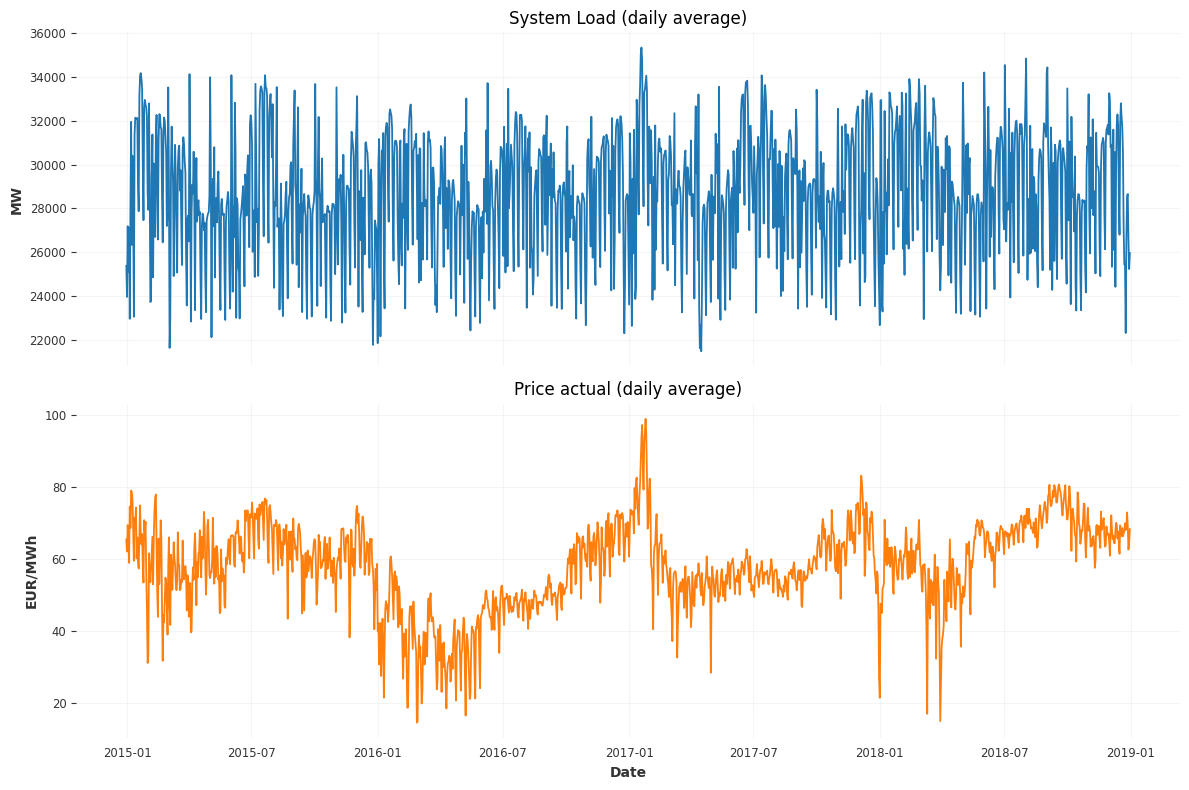

In [23]:
# Load & Price: Overall Trend (Hourly → Daily Mean, Denoised)
daily = energy_data[['total load actual','price actual']].resample('D').mean()

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(daily.index, daily['total load actual'], label='Load (daily mean)', color='tab:blue')
ax[0].set_ylabel('MW')
ax[0].set_title('System Load (daily average)')
ax[0].grid(True, alpha=0.3)

ax[1].plot(daily.index, daily['price actual'], label='Price actual (daily mean)', color='tab:orange')
ax[1].set_ylabel('EUR/MWh')
ax[1].set_title('Price actual (daily average)')
ax[1].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

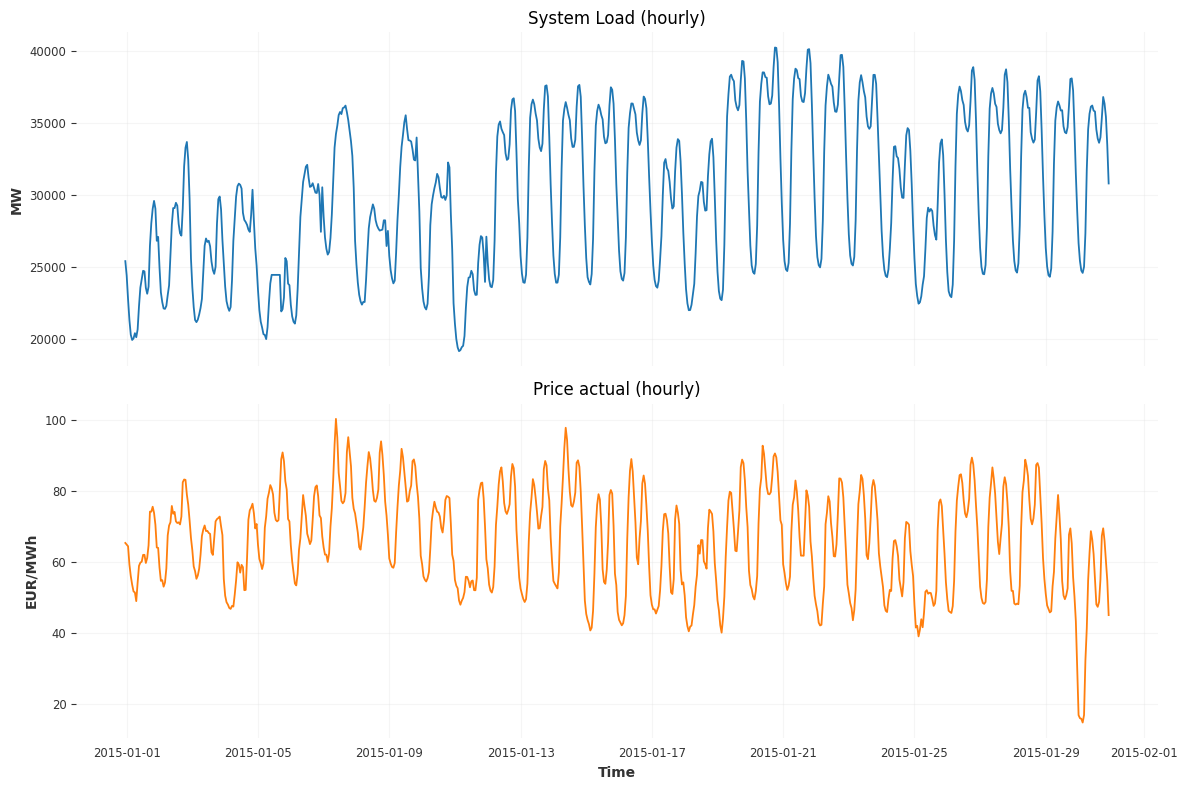

In [24]:
# Hourly Load & Price in a small time window
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(energy_data.index[:24*30], energy_data['total load actual'][:24*30], label='Load (hourly)', color='tab:blue')
ax[0].set_ylabel('MW')
ax[0].set_title('System Load (hourly)')
ax[0].grid(True, alpha=0.3)

ax[1].plot(energy_data.index[:24*30], energy_data['price actual'][:24*30], label='Price actual (hourly)', color='tab:orange')
ax[1].set_ylabel('EUR/MWh')
ax[1].set_title('Price actual (hourly)')
ax[1].grid(True, alpha=0.3)

plt.xlabel('Time')
plt.tight_layout()
plt.show()

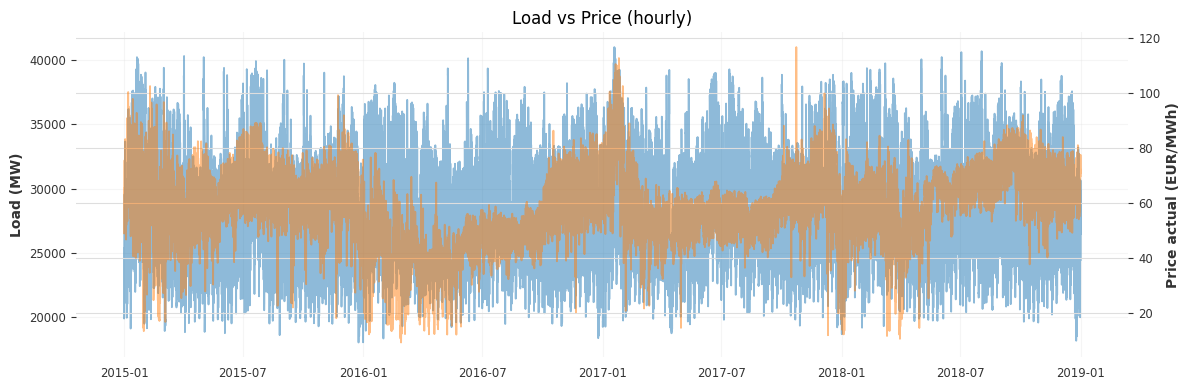

In [25]:
# Load & Price: Dual-Axis View (Hourly Detail)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(energy_data.index, energy_data['total load actual'], alpha=0.5, color='tab:blue')
ax.set_ylabel('Load (MW)')
ax.grid(True, alpha=0.3)
ax2 = ax.twinx()
ax2.plot(energy_data.index, energy_data['price actual'], alpha=0.5, color='tab:orange')
ax2.set_ylabel('Price actual (EUR/MWh)')
ax.set_title('Load vs Price (hourly)')   
plt.tight_layout()
plt.show()


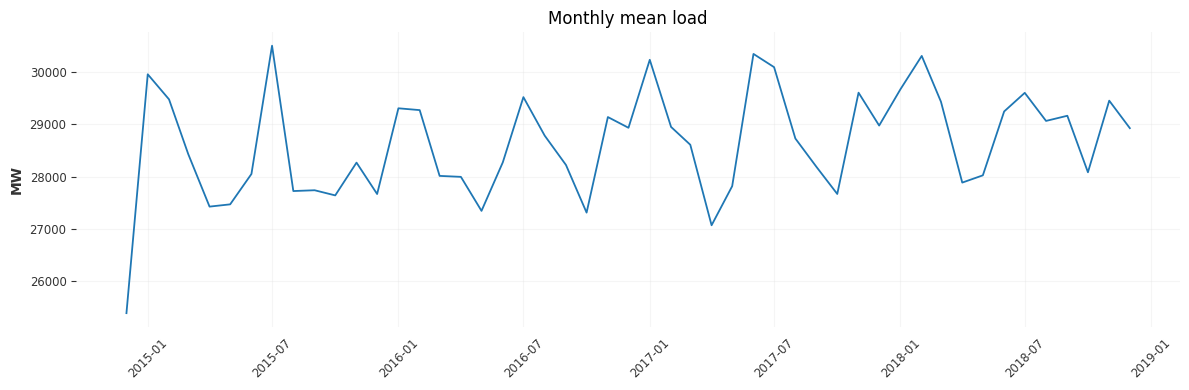

In [26]:
# Seasonality – Monthly

monthly = energy_data['total load actual'].resample('MS').mean()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly.index, monthly.values, color='tab:blue')
ax.set_title('Monthly mean load')
ax.set_ylabel('MW')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

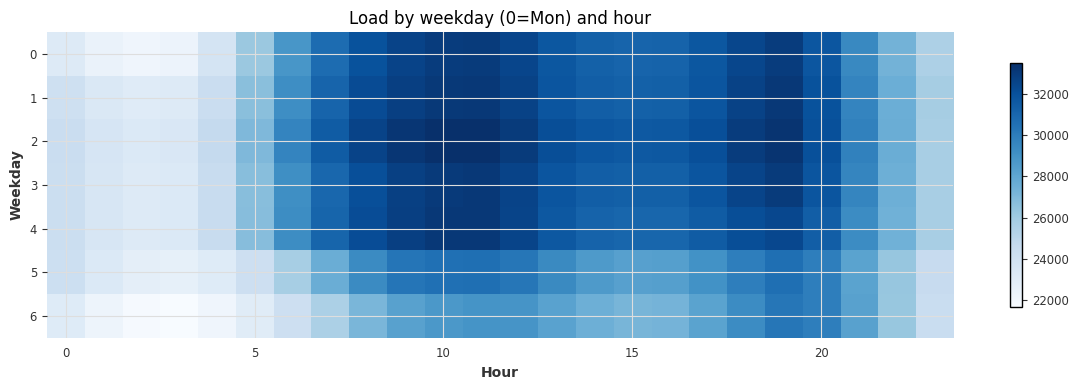

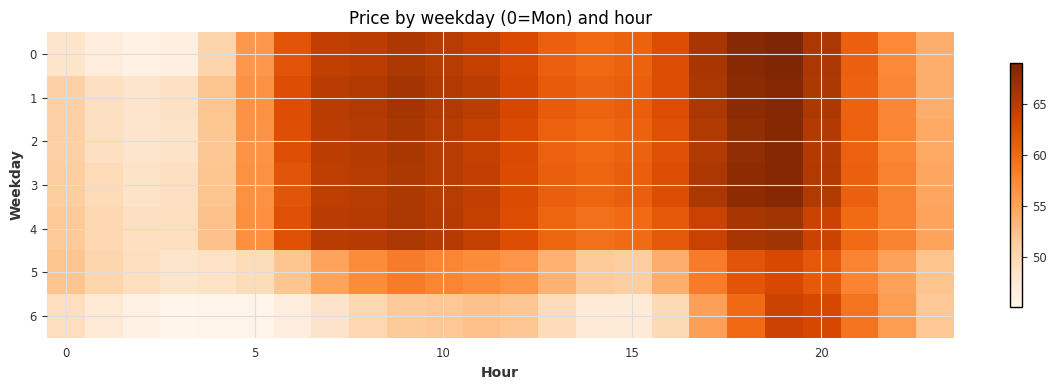

In [27]:
# Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['total load actual'].groupby([energy_data.index.dayofweek,energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(gp, aspect='auto', cmap='Blues')
ax.set_title('Load by weekday (0=Mon) and hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
fig.tight_layout()
plt.show()


# Price: Weekday–Hour Seasonality (Grouped by Hour)

gp = energy_data['price actual'].groupby([energy_data.index.dayofweek,
                                               energy_data.index.hour]).mean().unstack()
fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(gp, aspect='auto', cmap='Oranges')
ax.set_title('Price by weekday (0=Mon) and hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Weekday')
fig.colorbar(im, ax=ax, shrink=0.8)
fig.tight_layout()
plt.show()



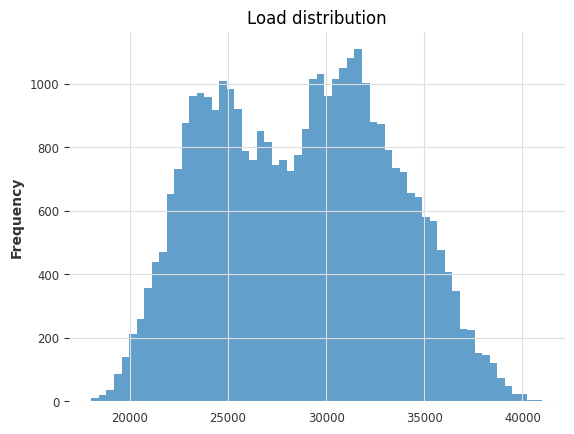

In [28]:
# load distribution
yL = energy_data["total load actual"]
yL.plot(kind="hist", bins=60, alpha=.7, title="Load distribution", color='tab:blue')
plt.show()

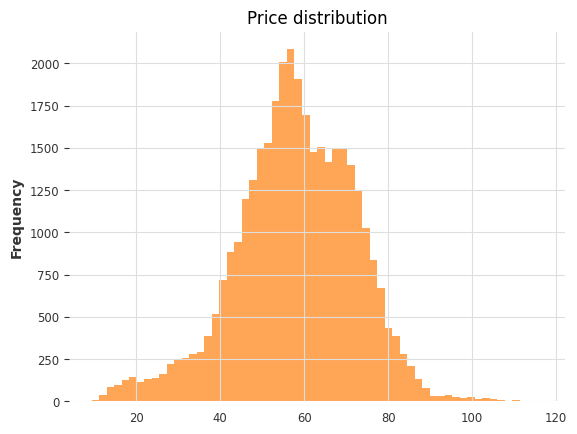

Price < 0 ratio: 0.0


In [29]:
# price distribution
yP = energy_data["price actual"]
yP.plot(kind="hist", bins=60, alpha=.7, title="Price distribution", color='tab:orange')
plt.show()
print("Price < 0 ratio:", (yP<0).mean())


~normarlization distribution, no need log1p transformation. No big difference between using mae and mse based on this distribution.

In [30]:
def plot_acf_clean(s, max_lag=200, title="", highlight=(), daily=False,
                   color='tab:blue', highlight_color='k'):
    s = s.dropna()
    if daily:
        s = s.resample("D").mean()

    fig, ax = plt.subplots(figsize=(12, 4))

    plot_acf(
        s, lags=max_lag, ax=ax, zero=False, alpha=0.05,
        vlines_kwargs={'colors': color, 'linewidth': 1.2, 'alpha': 0.95},
        marker='o'
    )

    ax.set_title(title)
    ax.set_xlim(0, max_lag)
    ax.set_ylim(-1.0, 1.0)
    ax.grid(True, alpha=0.3)

    for k in highlight:
        if k <= max_lag:
            ax.axvline(k, color=highlight_color, linestyle="--", linewidth=0.8, alpha=0.7)
            ax.text(k+1, 0.88, str(k), fontsize=9, alpha=0.7, color=highlight_color)

    plt.tight_layout()
    plt.show()

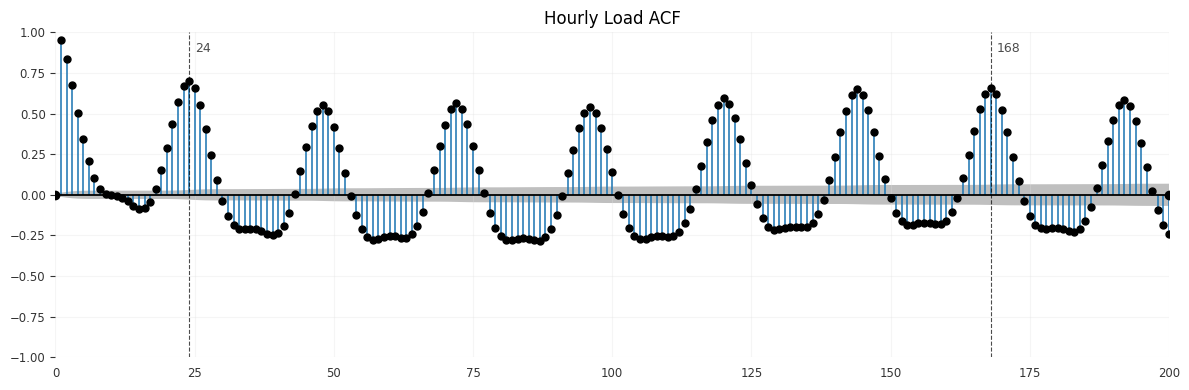

In [31]:
# Load: ACF (Hourly)
plot_acf_clean(energy_data['total load actual'], max_lag=200,
               title='Hourly Load ACF', color='tab:blue', highlight=(24, 168))

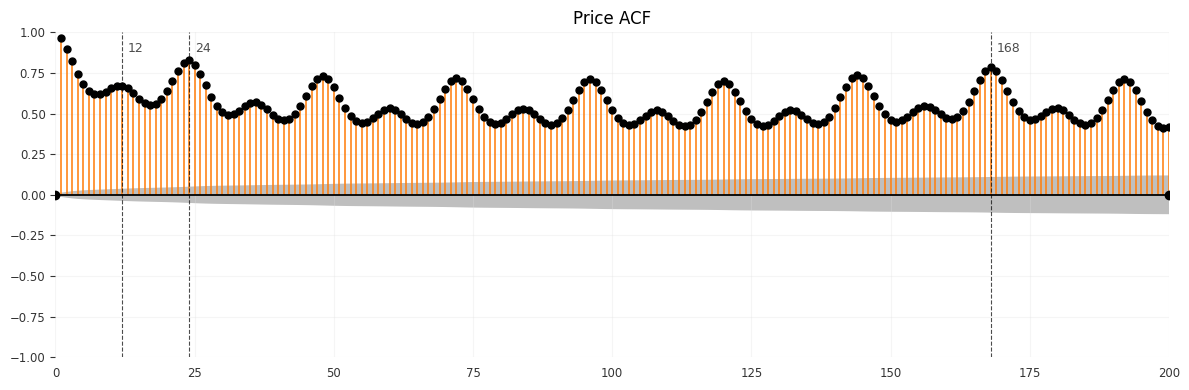

In [32]:
# Price: ACF (Hourly)
plot_acf_clean(energy_data['price actual'], max_lag=200,
               title='Price ACF', color='tab:orange', highlight=(12, 24, 168))

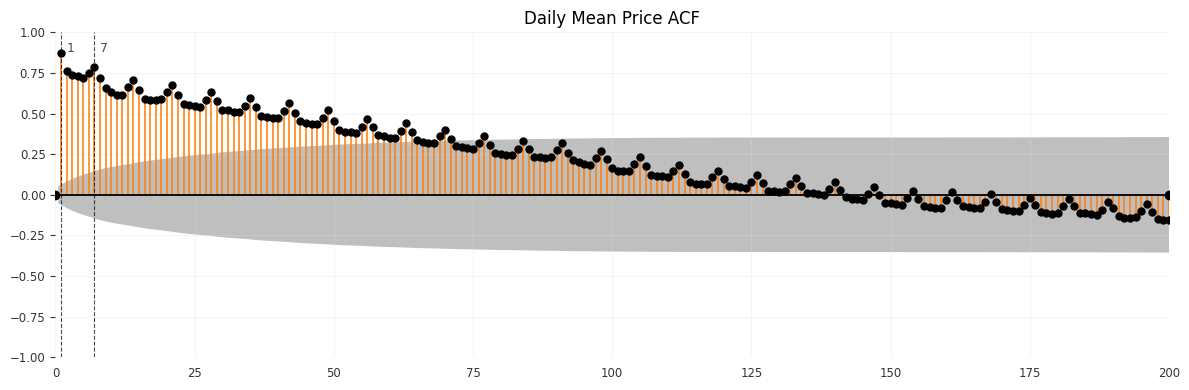

In [33]:
# Price: ACF (daily mean)
plot_acf_clean(energy_data['price actual'], max_lag=200,
               title='Daily Mean Price ACF', color='tab:orange', highlight=(1, 7, ), daily=True)

Findings:
- Daily seasonality
- Weeklly seasonality
- Persistence

actions: 
- Trees: 
    - lags=[1, 2, 3, 6, 12, 24, 25, 48, 168] relative to the last known time t
    - rolling w = [24, 168]
    - diff = [1, 24, 168]
- NN: 
    - Encoder Length >= 168
    - rolling w = [24, 168]
    - diff = [1, 24, 168]

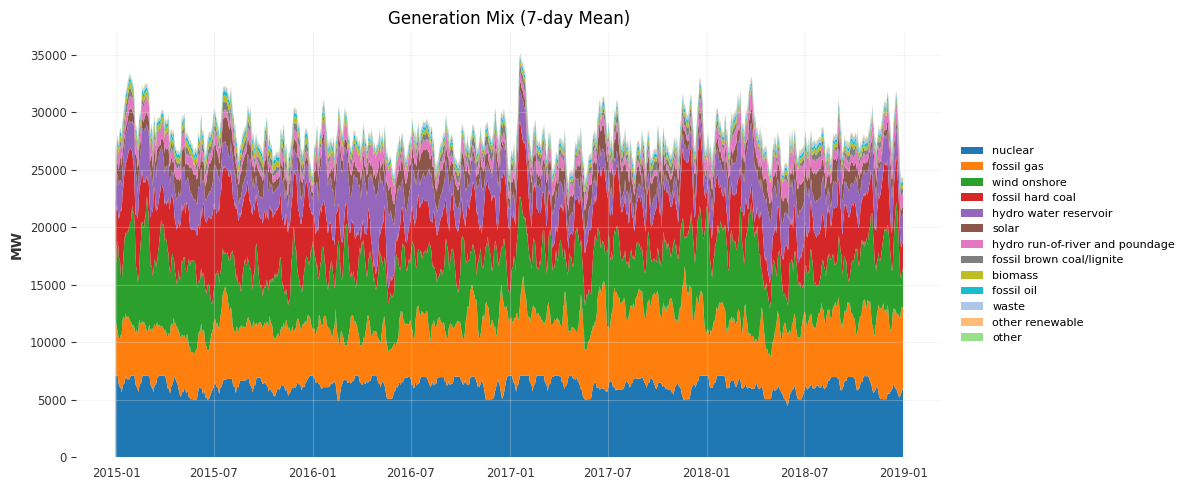

In [34]:
gen_cols = [c for c in energy_data.columns if c.startswith('generation ') and 'pumped storage consumption' not in c] 

# # Daily mean to reduce visual noise 
gen_daily = energy_data[gen_cols].resample('D').mean() 
gen_smooth = gen_daily.rolling(window=7, min_periods=1).mean()

order = gen_smooth.mean().sort_values(ascending=False).index
labels = [c.replace('generation ', '') for c in order]

base = list(plt.colormaps['tab20'].colors)
idx = list(range(0,20,2)) + list(range(1,20,2)) 
colors = [base[idx[i % 20]] for i in range(len(order))]


fig, ax = plt.subplots(figsize=(12,5))
ax.stackplot(gen_smooth.index, gen_smooth[order].T.values,
             labels=labels, colors=colors, linewidth=0)
ax.set_title('Generation Mix (7-day Mean)')
ax.set_ylabel('MW'); ax.grid(True, alpha=0.3)
ax.legend(ncols=1, fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout(); plt.show()


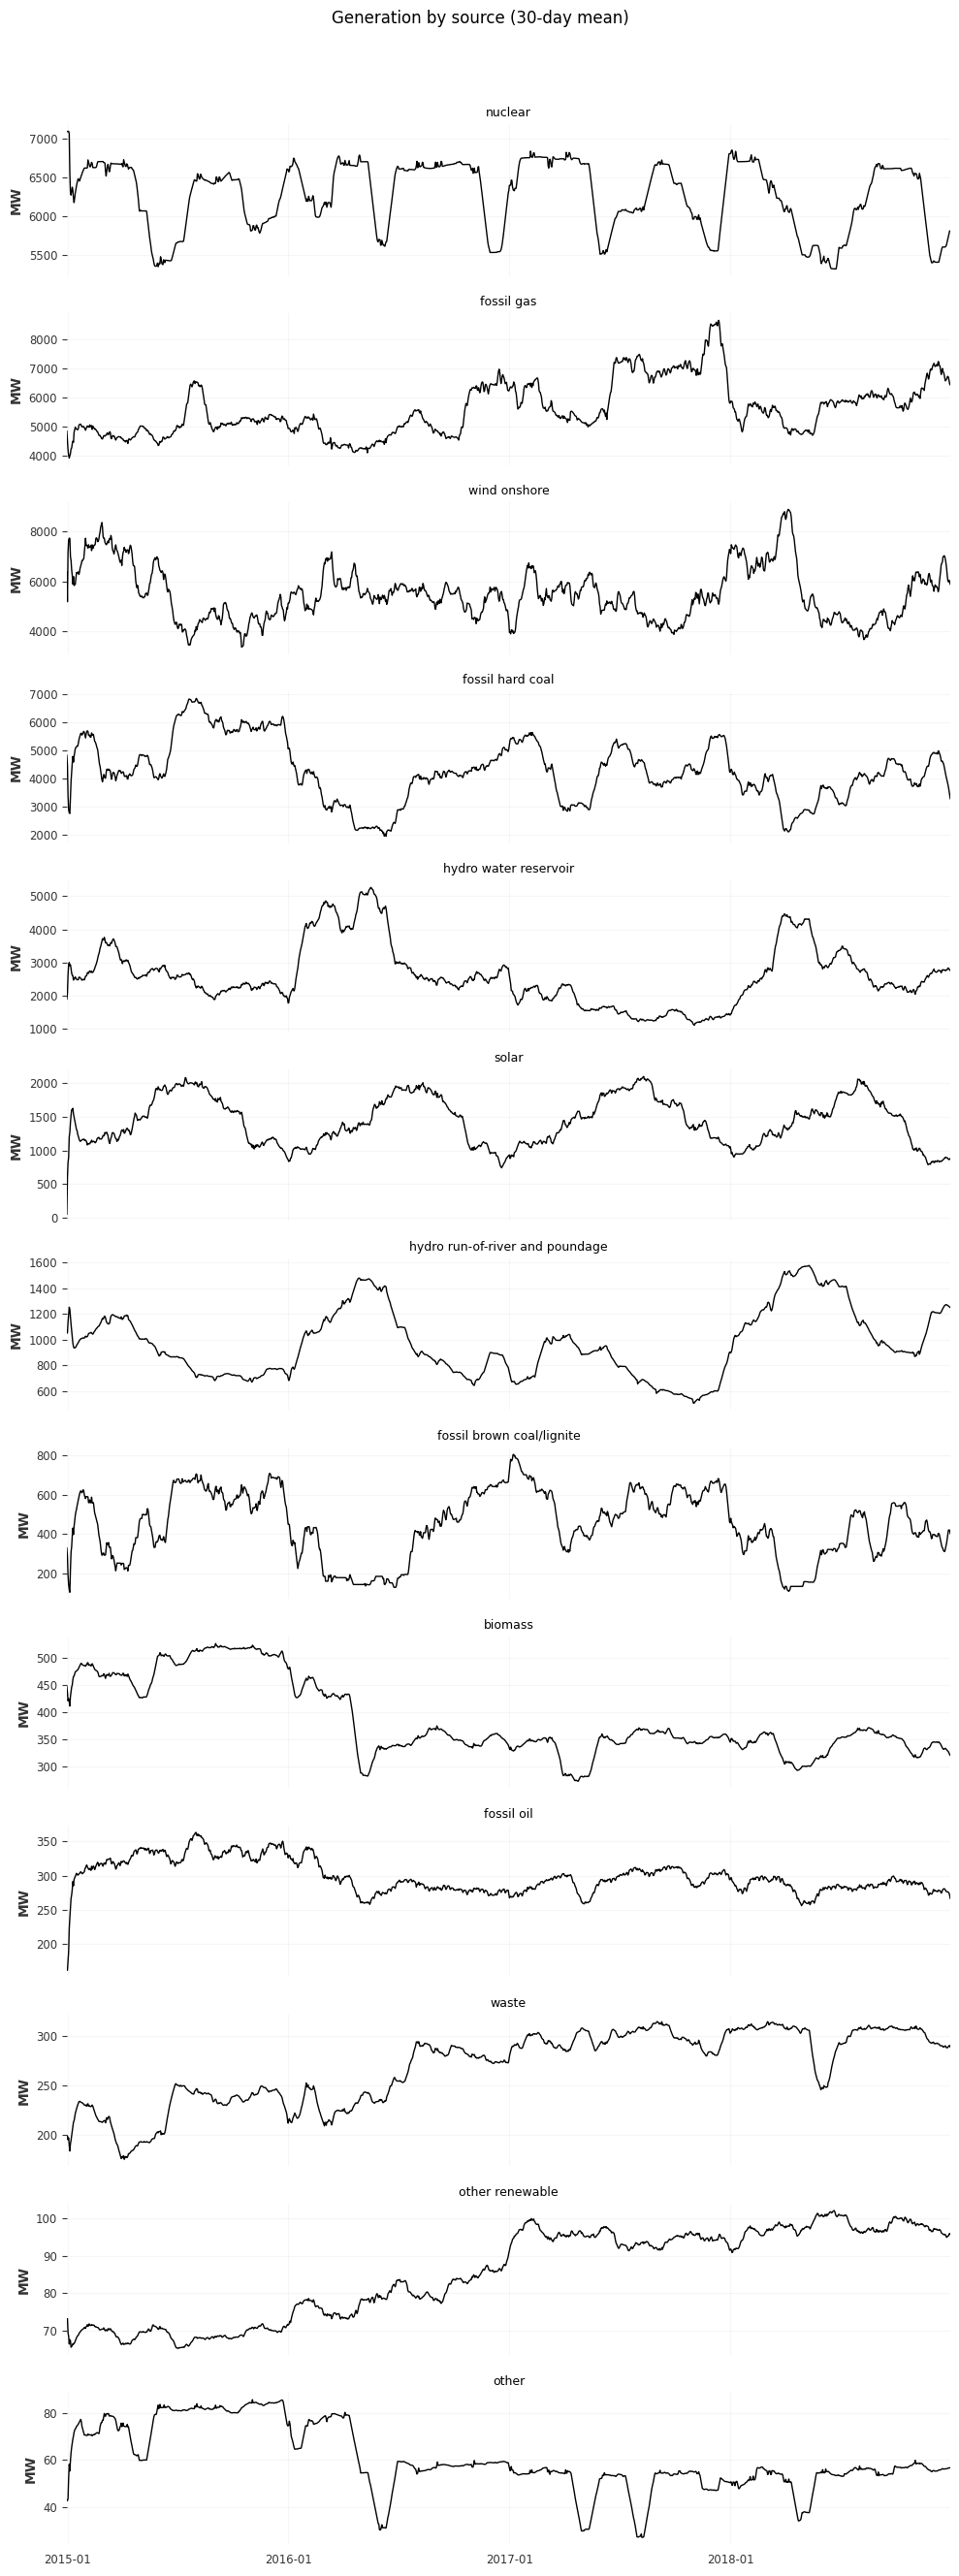

In [35]:
# Generation by Source (30-day Mean): Small Multiples

# 1) Prepare series: daily mean + 30-day rolling mean; order by long-run average
gen_cols = [c for c in energy_data.columns
            if c.startswith('generation ') and 'pumped storage consumption' not in c]
gen_daily  = energy_data[gen_cols].resample('D').mean()
gen_roll30 = gen_daily.rolling(30, min_periods=1).mean()
order = gen_roll30.mean().sort_values(ascending=False).index
titles = [c.replace('generation ', '') for c in order]

# 2) Small multiples: share the same X axis across plots, keep independent Y axes
n = len(order); ncols = 1
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2*nrows), sharex=True)  # sharex=True !
axes = axes.ravel()

xmin, xmax = gen_roll30.index.min(), gen_roll30.index.max()
locator = mdates.YearLocator()       
fmt     = mdates.DateFormatter('%Y-%m')

for i, col in enumerate(order):
    ax = axes[i]
    ax.plot(gen_roll30.index, gen_roll30[col], linewidth=1.0)
    ax.set_title(titles[i], fontsize=9)
    ax.set_xlim(xmin, xmax)          
    ax.grid(True, alpha=0.25)
    if i % ncols == 0:
        ax.set_ylabel('MW')          
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)

# 3) Hide X labels on inner plots; show them only on the bottom row
for ax in axes:
    ax.label_outer()

# Turn off any unused subplots (when grid has extra slots)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Generation by source (30-day mean)', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


**Findings**

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.


#### 1.3.2 weather data visualization

In [36]:
def ez_box(df, x, y, title=None, percent=False, figsize=(12,4), rotation=12, palette='Set2'):
    """Simple, clean boxplot with outliers kept"""
    sns.set_theme(style="whitegrid", context="notebook")
    flierprops = dict(marker='o', markersize=2, markerfacecolor='none',
                      markeredgecolor='0.3', alpha=0.5)
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    sns.boxplot(data=df, x=x, y=y,
                showfliers=True, fliersize=2, flierprops=flierprops,
                palette=palette, width=0.6, linewidth=1.2, ax=ax)
    ax.set(title=title or f'{y} by {x}', xlabel=x, ylabel=y)
    if rotation: ax.tick_params(axis='x', labelrotation=rotation)
    if percent:  ax.set_ylim(-5, 105)
    ax.grid(True, axis='y', alpha=0.25)
    return ax


<Axes: title={'center': 'Temperature by City'}, xlabel='city_name', ylabel='temp'>

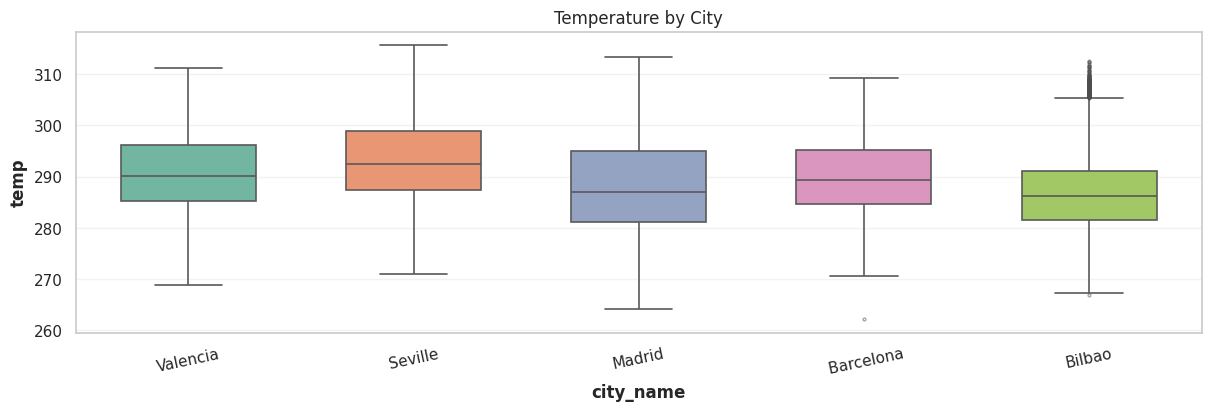

In [37]:
# Temperature
ez_box(weather_data, 'city_name', 'temp', 'Temperature by City')

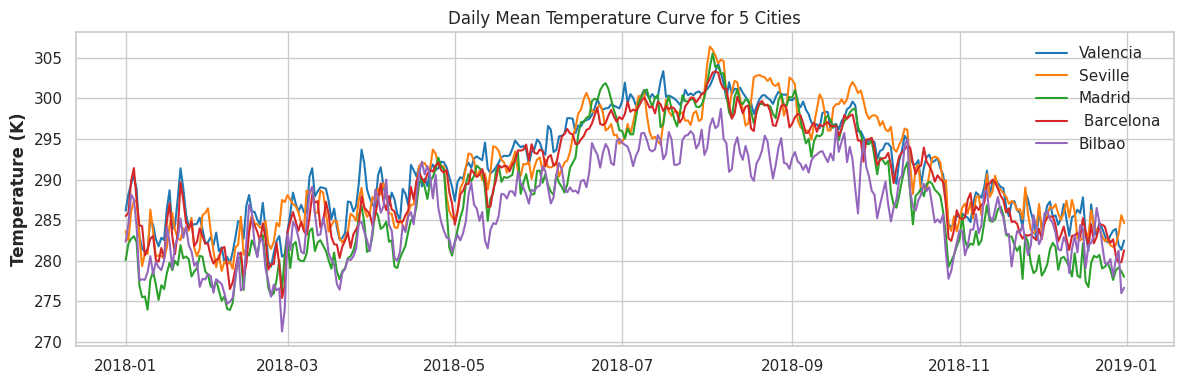

In [38]:
# plot daily mean temperature curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_temp = weather_data[weather_data['city_name'] == city]['temp'].sort_index().resample('D').mean()
    ax.plot(city_temp[-365:].index, city_temp[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Temperature Curve for 5 Cities')
ax.set_ylabel('Temperature (K)')
ax.legend()
plt.tight_layout()
plt.show()


Findings: tempereture envolves similar across different cities

<Axes: title={'center': 'Pressure Distribution by City'}, xlabel='city_name', ylabel='pressure'>

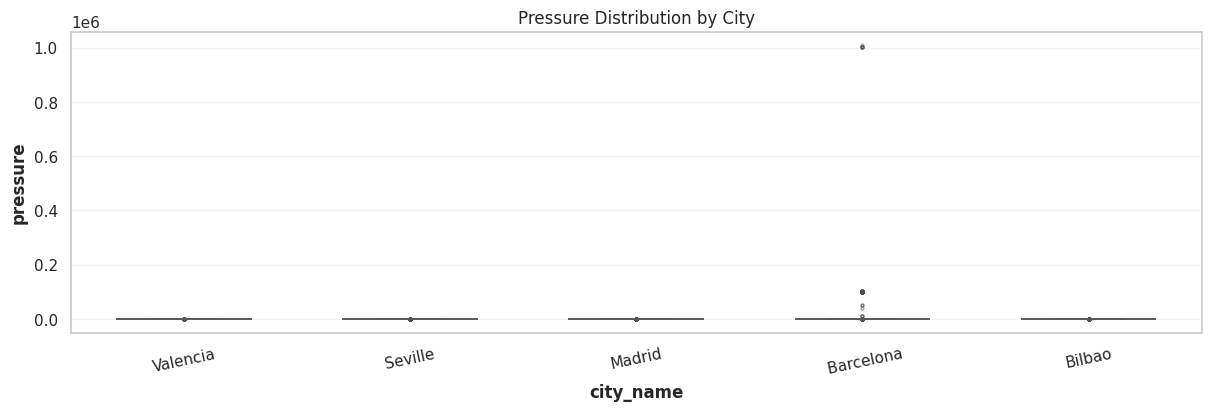

In [39]:
# Pressure
ez_box(weather_data, 'city_name', 'pressure', 'Pressure Distribution by City')

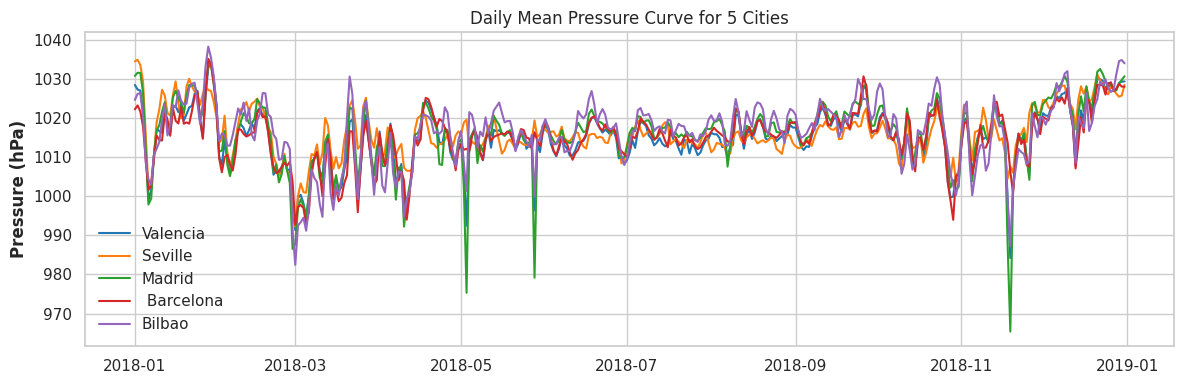

In [40]:
# pressure daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_pressure = weather_data[weather_data['city_name'] == city]['pressure'].sort_index().resample('D').mean()
    ax.plot(city_pressure[-365:].index, city_pressure[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Pressure Curve for 5 Cities')
ax.set_ylabel('Pressure (hPa)')
ax.legend()
plt.tight_layout()
plt.show()

Findings: 
- Pressure envoles similar across different cities.
- Outliers: the pressure unit might be wrong

<Axes: title={'center': 'Wind Speed Distribution by City'}, xlabel='city_name', ylabel='wind_speed'>

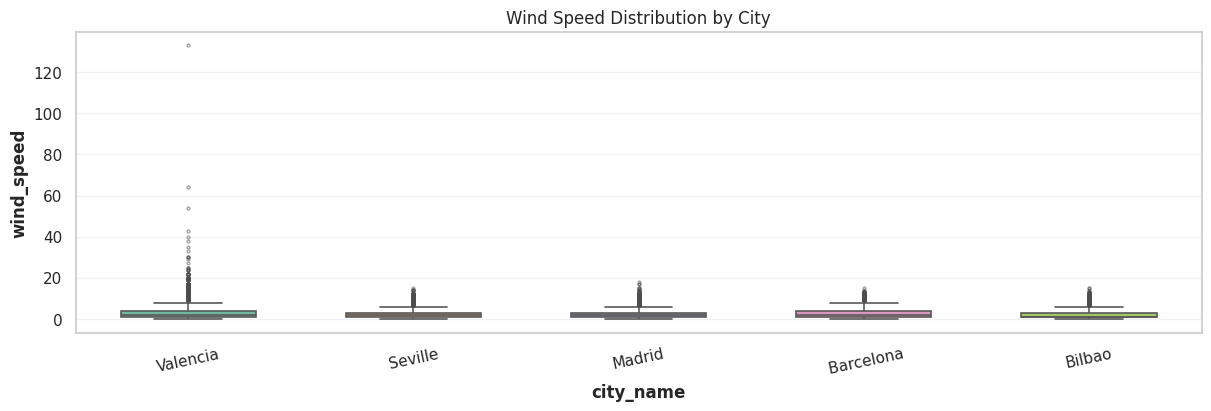

In [41]:
# visualization of wind speed data
ez_box(weather_data, 'city_name', 'wind_speed', 'Wind Speed Distribution by City')

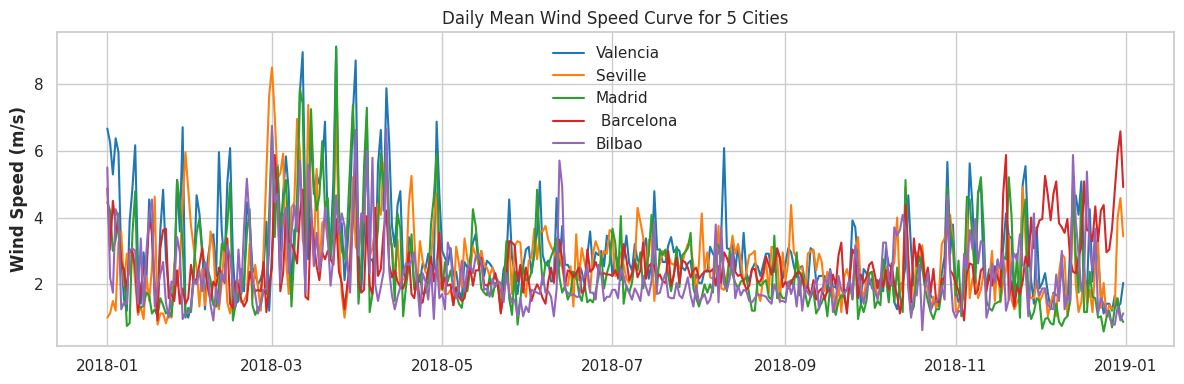

In [42]:
# wind speed daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):    
    city_wind = weather_data[weather_data['city_name'] == city]['wind_speed'].sort_index().resample('D').mean()
    ax.plot(city_wind[-365:].index, city_wind[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Wind Speed Curve for 5 Cities')
ax.set_ylabel('Wind Speed (m/s)')
ax.legend()
plt.tight_layout()
plt.show()

Findings:
- wind speed envolves differently between different cities
- Outliers: high speed

<Axes: title={'center': 'Humidity Distribution by City'}, xlabel='city_name', ylabel='humidity'>

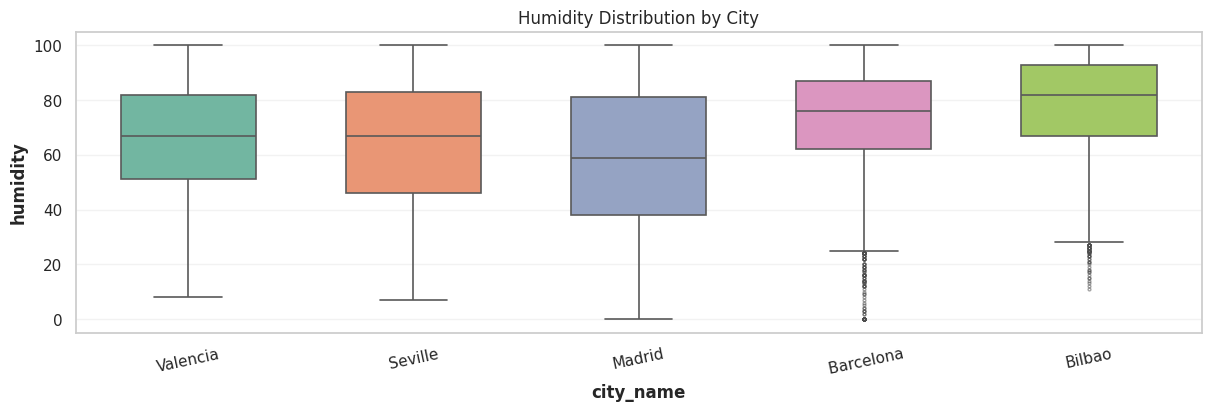

In [43]:
# humidity
ez_box(weather_data, 'city_name', 'humidity', 'Humidity Distribution by City')

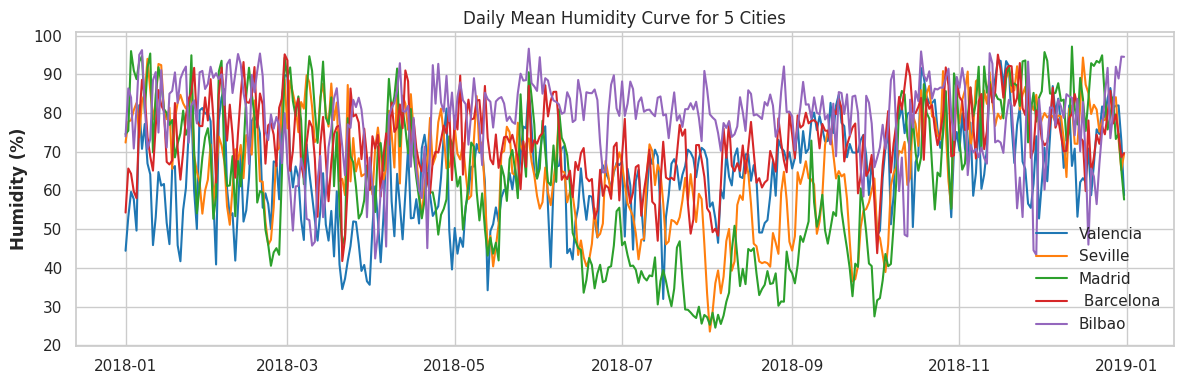

In [44]:
# humidity daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_humidity = weather_data[weather_data['city_name'] == city]['humidity'].sort_index().resample('D').mean()
    ax.plot(city_humidity[-365:].index, city_humidity[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Humidity Curve for 5 Cities')
ax.set_ylabel('Humidity (%)')
ax.legend()
plt.tight_layout()
plt.show()

Findings:
- Humidity envolves differently between different cities

<Axes: title={'center': 'Cloudiness Distribution by City'}, xlabel='city_name', ylabel='clouds_all'>

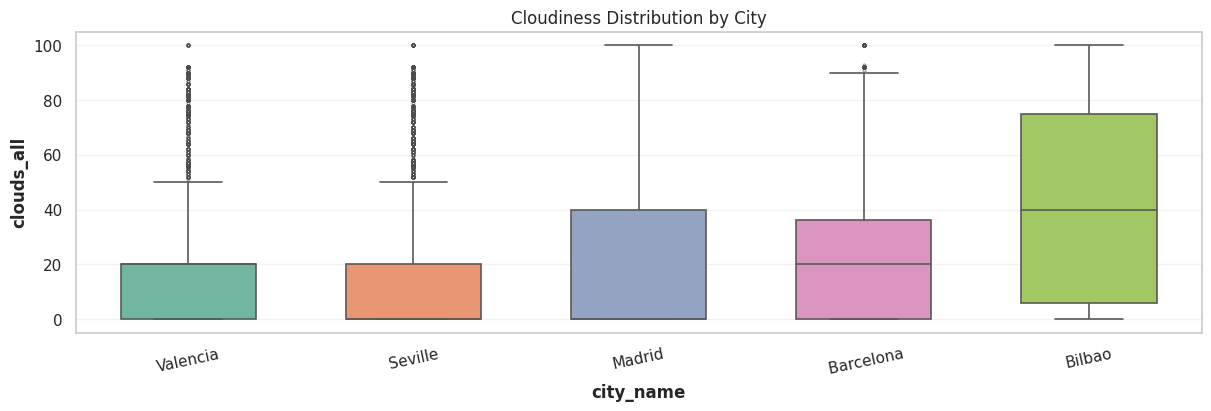

In [45]:
# Clouds_all
ez_box(weather_data, 'city_name', 'clouds_all', 'Cloudiness Distribution by City', percent=True)

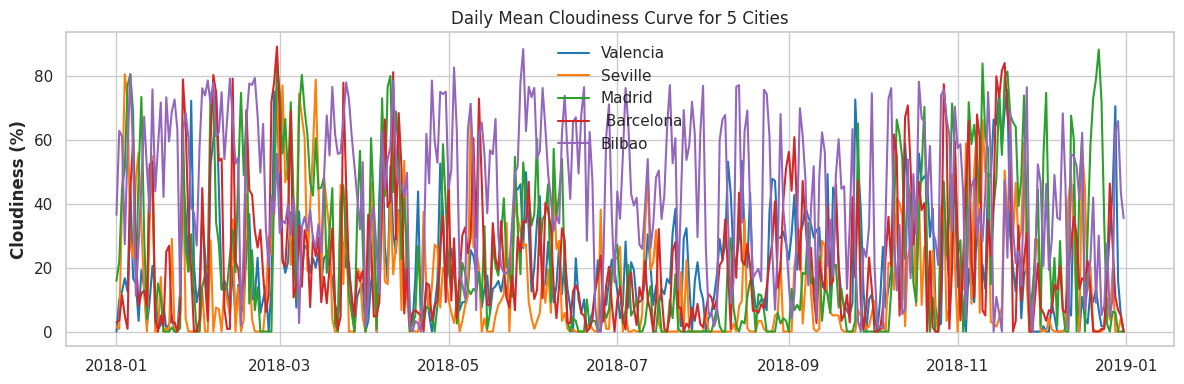

In [46]:
# clouds_all daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_clouds = weather_data[weather_data['city_name'] == city]['clouds_all'].sort_index().resample('D').mean()
    ax.plot(city_clouds[-365:].index, city_clouds[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Cloudiness Curve for 5 Cities')
ax.set_ylabel('Cloudiness (%)')
ax.legend()
plt.tight_layout()
plt.show()

Findings:

- Cloudiness shows a heavy zero mass and a long right tail in several cities.
- Cloudiness envolves differently among different cities

<Axes: title={'center': 'Rain (1h) Distribution by City'}, xlabel='city_name', ylabel='rain_1h'>

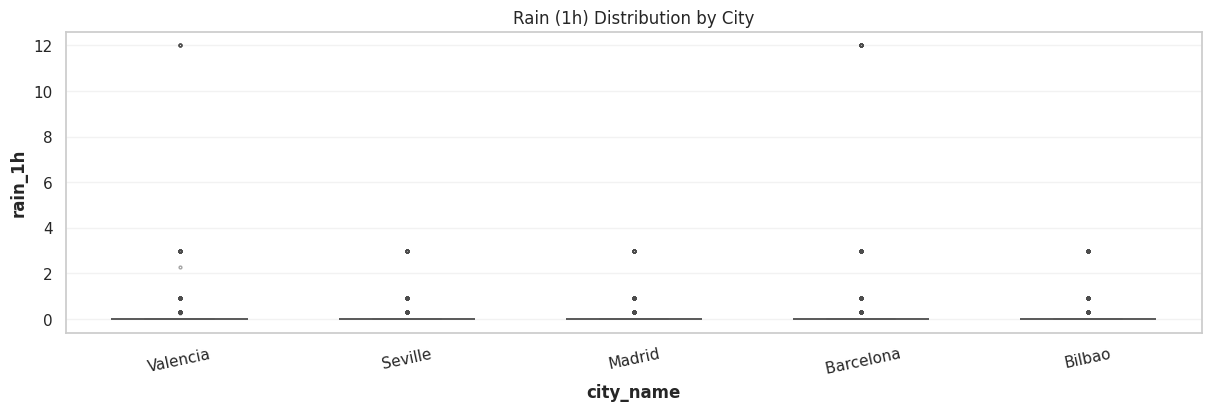

In [47]:
# visualization of rain_1h data
ez_box(weather_data, 'city_name', 'rain_1h', 'Rain (1h) Distribution by City')

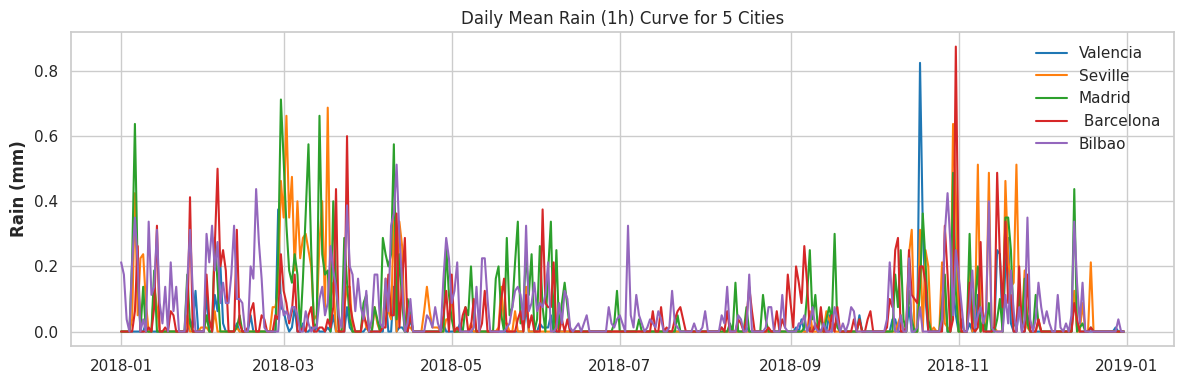

In [48]:
# rain_1h daily mean curve for 5 cities
fig, ax = plt.subplots(figsize=(12,4))
for i, city in enumerate(weather_data['city_name'].unique()):
    city_rain = weather_data[weather_data['city_name'] == city]['rain_1h'].sort_index().resample('D').mean()
    ax.plot(city_rain[-365:].index, city_rain[-365:].values, label=city, color=plt.cm.tab10(i))
ax.set_title('Daily Mean Rain (1h) Curve for 5 Cities')
ax.set_ylabel('Rain (mm)')
ax.legend()
plt.tight_layout()
plt.show()

In [49]:
weather_data["rain_1h"].describe()

count    175320.000000
mean          0.069308
std           0.385915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: rain_1h, dtype: float64

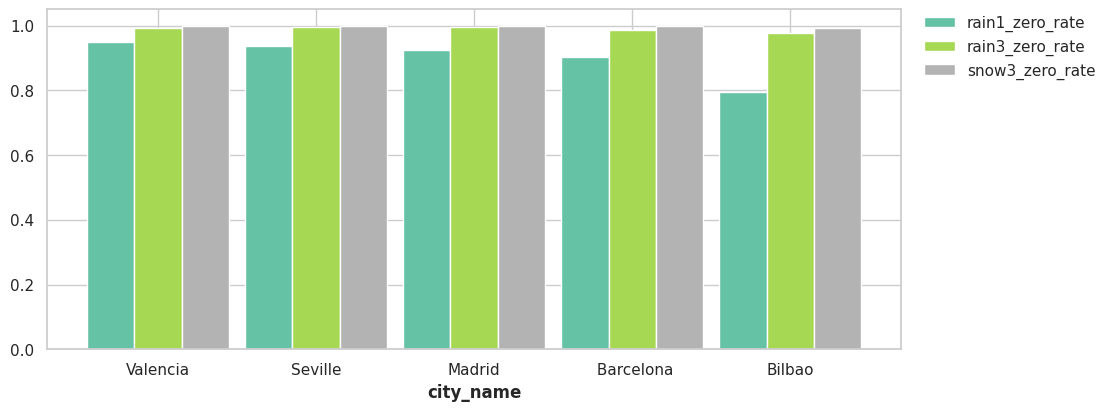

In [50]:
# ---- Zero Rain/Snow Analysis ----
def zero_ratio(s):
    return (s==0).mean()


zr = weather_data.groupby('city_name').agg(
    rain1_zero_rate=('rain_1h', zero_ratio),
    rain3_zero_rate=('rain_3h', zero_ratio),
    snow3_zero_rate=('snow_3h', zero_ratio),
).sort_values(['rain1_zero_rate', 'rain3_zero_rate', 'snow3_zero_rate'], ascending=False)

fig, ax = plt.subplots(figsize=(11,4), constrained_layout=True)
zr.plot(kind='bar', ax=ax, colormap='Set2', width=0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, borderaxespad=0)
ax.tick_params(axis='x', labelrotation=0)
plt.show()


Findings:
- It doesn't rain or snow on most days across all 5 cities

### 1.4 Summary

**Key Findings**

- Load has highly autocorrelation with lag 1, 2, 3, 12, 24, 48, 168

- Daily price has highly autocorrelation with lag 1, 2, 3, 12, 24, 48, 168

- Seasonality: Strong annual cycle and clear weekday–hour pattern in load; solar peaks in summer, near-zero in winter.

- Load–Price relation: Co-movement is visible, but price is much more volatile with occasional spikes.

- Renewables: Onshore wind changes a lot from week to week. Solar is smaller overall but very seasonal.

- Fossil Gas/coal： average level can shift for several weeks or months.

- Hydro: Reservoir and run-of-river plants smooth peaks and valleys and show clear seasons.

- It doesn't rain or snow on most days

- temperature and pressure evolve in a similar trend for 5 cities

- wind speed, humunity, clouds_all have different pattern among different cities


**Action Plan**
- clean weather data: rolling clipping temp, pressure, wind_speed, huminity
  
- pivot weather data to wide format by expanding city_name
  
- temperature: use temp_mean, temp_min, temp_max, temp_range
  
- pressure: use pressure_mean
  
- wind_speed: use mean, max
  
- humidity: use mean
  
- clouds_all: use mean, heavy_frac among all cities, if_heavy
  
- rain_1h: use rain_any, rain_mean, rain_sum, rain_sum24
  
- merge energy and weather data
  
- parse datetime and add time features: hour, day of week, is_weekend, month, season, sin/cos, holidays
  
- Define baseline: take load and price values of previous day at the same time: lag 24
  
- split trian, validation, and test(time-based split)
  
- load lags: besides lag 24, add lag 1,2,3,24,48
  
- load rolling features: rolling mean (and maybe std) over 3, 12, 24, 168 hours, computed using only past data (no leakage)
  
- price lags: besides lag 24, add lag 1,2,3,12,24,48
  
- price rolling features: rolling mean (±std) over 3, 12, 24, 168 hours, using only history
  
- diff(3, 12, 24, 168)
  
- one fold first before applying CV on models xgboost and lstm
  
- point forecasting + probability forecasting
  
- hybrid models(xgboost, lstm, tft)

## 2. Data Preprocessing

### 2.1 weather data preprocessing

In [51]:
def roll_clip_mad(
    df: pd.DataFrame,
    col: str,
    group: str = "city_name",
    w: int = 45*24,          # window in hours (e.g., 45 days for temperature)
    k: float = 5.0,          # robustness factor (larger = more conservative)
    n_min: int = 24,         # minimum past samples required to enable clipping
    lower_phys: float | None = None,   # optional physical lower bound
    upper_phys: float | None = None,   # optional physical upper bound
) -> pd.DataFrame:

    out = df.copy().sort_values([group, df.index.name])
    x = out[col].astype(float)

    # rolling median and MAD per city
    med = x.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=n_min).median()) # We perform a groupby using an explicit grouping Series (a Series-based grouper) rather than referring to a column name directly.
    mad = (x - med).abs().groupby(out[group]).transform(
            lambda s: s.rolling(w, min_periods=n_min).median())
    sigma = (1.4826 * mad).clip(lower=1e-6)  # avoid zero-width bands

    # enable clipping only when we have enough past data
    cnt = x.groupby(out[group]).transform(lambda s: s.rolling(w, min_periods=n_min).count())

    lo = med - k * sigma
    hi = med + k * sigma

    x_clip = x.where(cnt < n_min, x.clip(lower=lo, upper=hi))

    # optional physical bounds
    if lower_phys is not None:
        x_clip = x_clip.clip(lower=lower_phys)
    if upper_phys is not None:
        x_clip = x_clip.clip(upper=upper_phys)

    out[col + "_clip"] = x_clip
    return out

# Temperature (Kelvin): conservative bands for all cities
wd = roll_clip_mad(weather_data, col="temp", w=45*24, k=5, n_min=24*7, lower_phys=250, upper_phys=325)

# Pressure (after unit fix), shorter window
wd["pressure"] = np.where(wd["pressure"] > 2000, wd["pressure"]/1000, wd["pressure"])
wd = roll_clip_mad(wd, col="pressure", w=21*24, k=5, n_min=24*7, lower_phys=870, upper_phys=1100)

# wind speed
wd = roll_clip_mad(wd, col="wind_speed", w=30*24, k=5, n_min=24*7, lower_phys=0, upper_phys=60)

# humidity
wd = roll_clip_mad(wd, col="humidity", w=21*24, k=5, n_min=24*7, lower_phys=0, upper_phys=100)

In [52]:
wd.columns

Index(['city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all',
       'weather_id', 'temp_clip', 'pressure_clip', 'wind_speed_clip',
       'humidity_clip'],
      dtype='object')

In [53]:
keep_wcols = ["city_name",
              "temp_clip",
              "pressure_clip",
              "wind_speed_clip",
              "humidity_clip",
              "clouds_all",
              "rain_1h",
              ] # for the sake of simplicity, only keep these weather columns

cwd = wd[keep_wcols]

In [54]:
cwd.head() # we will upper clip rain_1h after splitting training and test sets

city_name  temp_clip  pressure_clip  \
time                                                              
2014-12-31 23:00:00+00:00   Barcelona    281.625         1035.0   
2015-01-01 00:00:00+00:00   Barcelona    281.625         1035.0   
2015-01-01 01:00:00+00:00   Barcelona    281.286         1036.0   
2015-01-01 02:00:00+00:00   Barcelona    281.286         1036.0   
2015-01-01 03:00:00+00:00   Barcelona    281.286         1036.0   

                           wind_speed_clip  humidity_clip  clouds_all  rain_1h  
time                                                                            
2014-12-31 23:00:00+00:00              7.0          100.0           0      0.0  
2015-01-01 00:00:00+00:00              7.0          100.0           0      0.0  
2015-01-01 01:00:00+00:00              7.0          100.0           0      0.0  
2015-01-01 02:00:00+00:00              7.0          100.0           0      0.0  
2015-01-01 03:00:00+00:00              7.0          100.0           0      0.0

<Axes: title={'center': 'Clipped Temperature by City'}, xlabel='city_name', ylabel='temp_clip'>

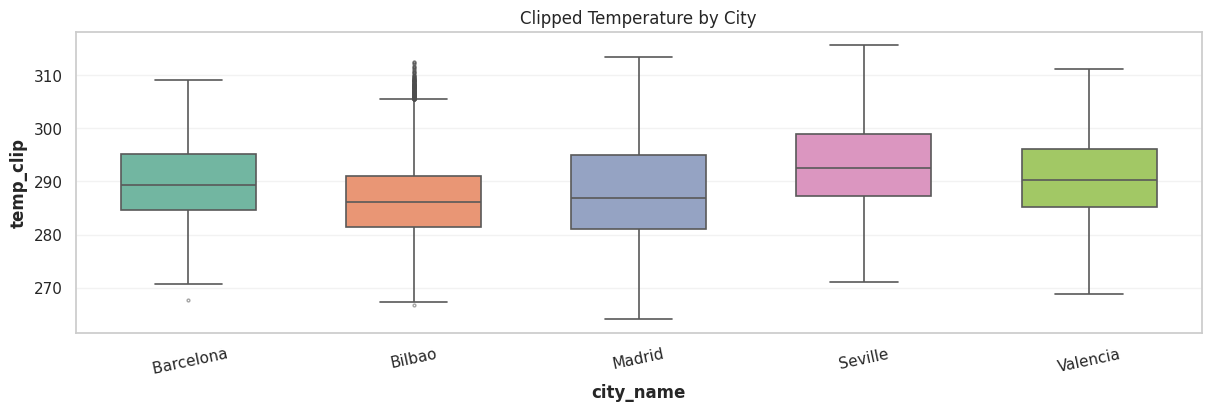

In [55]:
# visualization again after clipping
# 1) Temperature
ez_box(cwd, 'city_name', 'temp_clip', 'Clipped Temperature by City')

<Axes: title={'center': 'Clipped Pressure by City'}, xlabel='city_name', ylabel='pressure_clip'>

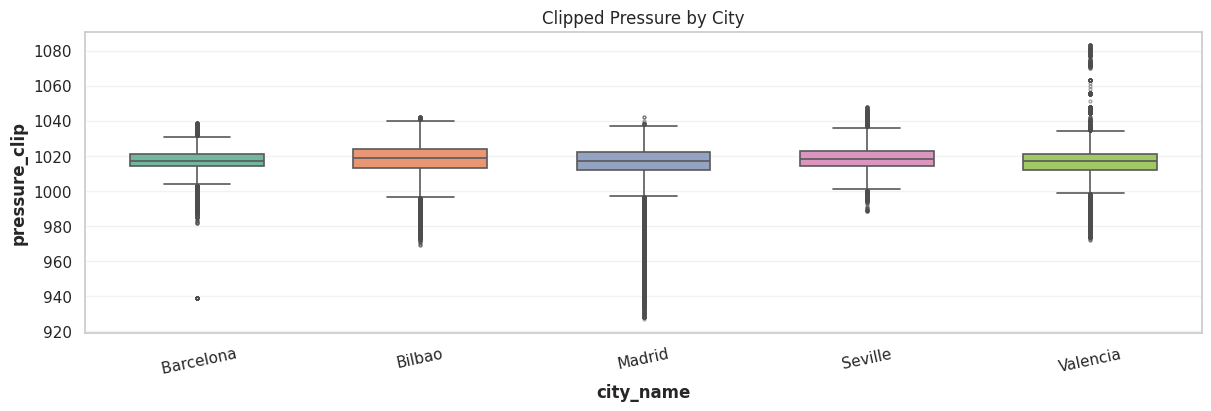

In [56]:
# Pressure
ez_box(cwd, 'city_name', 'pressure_clip', 'Clipped Pressure by City')

<Axes: title={'center': 'Clipped Wind Speed by City'}, xlabel='city_name', ylabel='wind_speed_clip'>

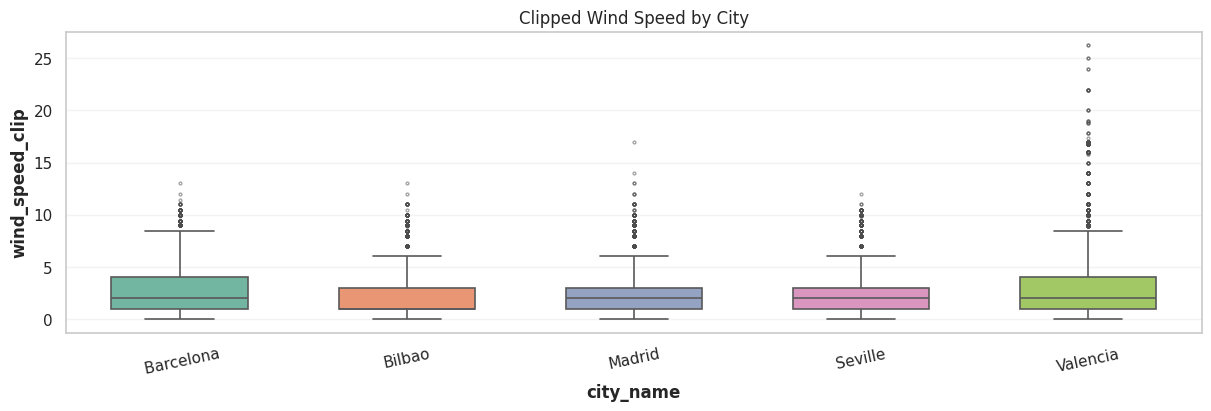

In [57]:
# wind speed
ez_box(cwd, 'city_name', 'wind_speed_clip', 'Clipped Wind Speed by City')

<Axes: title={'center': 'Clipped Humidity by City'}, xlabel='city_name', ylabel='humidity_clip'>

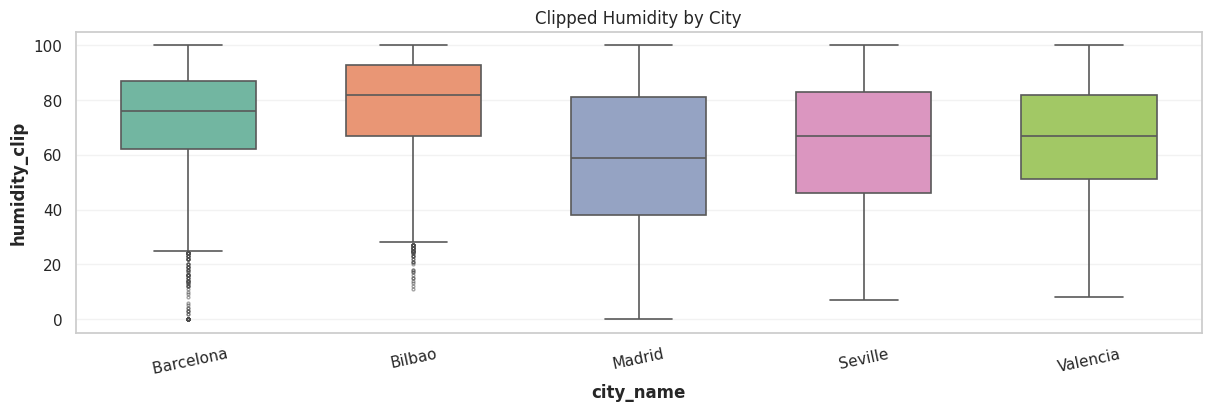

In [58]:
# humidity_clip
ez_box(cwd, 'city_name', 'humidity_clip', 'Clipped Humidity by City')

In [59]:
# pivot to wide format

vars_to_expand = ['temp_clip', 'pressure_clip', 'wind_speed_clip', 'humidity_clip', "clouds_all", "rain_1h"]
wide = cwd.pivot_table(index="time", columns="city_name", values=vars_to_expand, aggfunc="first")

new_cols = []
for col in wide.columns:
    var, city = col
    var = var.strip()
    city = city.strip()
    new_cols.append(f"{var}_city_{city}")
wide.columns = new_cols

wide_weather = wide.sort_index(axis=1)

In [60]:
# reduce temperature dimension, I know, 5 to 5.

temp_cols = [c for c in wide_weather.columns if c.startswith('temp_clip_city_')]
wide_weather["temp_mean"] = wide_weather[temp_cols].mean(axis=1)
wide_weather["temp_min"] = wide_weather[temp_cols].min(axis=1)
wide_weather["temp_max"] = wide_weather[temp_cols].max(axis=1)
wide_weather["temp_range"] = wide_weather["temp_max"] - wide_weather["temp_min"]
wide_weather["temp_rolling_mean_24"] = wide_weather["temp_mean"].rolling(window=24, min_periods=1).mean()

# reduce pressure dimension

pres_cols = [c for c in wide_weather.columns if c.startswith('pressure_clip_city_')]
wide_weather["pressure_mean"] = wide_weather[pres_cols].mean(axis=1)

# reduce wind speed dimension
wind_cols = [c for c in wide_weather.columns if c.startswith('wind_speed_clip_city_')]
wide_weather["wind_speed_mean"] = wide_weather[wind_cols].mean(axis=1)
wide_weather["wind_speed_max"] = wide_weather[wind_cols].max(axis=1)

# reduce humidity dimension
humidity_cols = [c for c in wide_weather.columns if c.startswith('humidity_clip_city_')]
wide_weather["humidity_mean"] = wide_weather[humidity_cols].mean(axis=1)

# reduce clouds_all dimension
cloud_tau = 60 # threshold for heavy clouds

cloud_cols = [c for c in wide_weather.columns if c.startswith('clouds_all_city_')]
wide_weather["clouds_all_mean"] = wide_weather[cloud_cols].mean(axis=1)
wide_weather["clouds_heavy_frac"] = wide_weather[cloud_cols].gt(cloud_tau).sum(axis=1) / len(cloud_cols)

# reduce rain_1h dimension
rain_cols = [c for c in wide_weather.columns if c.startswith('rain_1h_city_')]
wide_weather["rain_1h_mean"] = wide_weather[rain_cols].mean(axis=1)
wide_weather["rain_1h_any"] = wide_weather[rain_cols].gt(0).any(axis=1).astype(int)
wide_weather["rain_sum24"] = wide_weather[rain_cols].sum(axis=1).rolling(window=24, min_periods=1).sum()

wide_weather.drop(columns=temp_cols + pres_cols + humidity_cols + wind_cols + cloud_cols + rain_cols, inplace=True)

In [61]:
wide_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp_mean             35064 non-null  float64
 1   temp_min              35064 non-null  float64
 2   temp_max              35064 non-null  float64
 3   temp_range            35064 non-null  float64
 4   temp_rolling_mean_24  35064 non-null  float64
 5   pressure_mean         35064 non-null  float64
 6   wind_speed_mean       35064 non-null  float64
 7   wind_speed_max        35064 non-null  float64
 8   humidity_mean         35064 non-null  float64
 9   clouds_all_mean       35064 non-null  float64
 10  clouds_heavy_frac     35064 non-null  float64
 11  rain_1h_mean          35064 non-null  float64
 12  rain_1h_any           35064 non-null  int64  
 13  rain_sum24            35064 non-null  float64
dtypes: float64(13), int64(1

In [62]:
wide_weather.describe()

temp_mean      temp_min      temp_max    temp_range  \
count  35064.000000  35064.000000  35064.000000  35064.000000   
mean     289.707683    285.161925    294.265310      9.103385   
std        7.254228      7.087652      7.648556      3.221576   
min      271.941862    264.132000    274.150000      0.620000   
25%      284.098877    279.930000    288.296000      6.800000   
50%      289.036200    284.930000    293.529500      8.810000   
75%      295.100500    290.380000    299.680000     11.060000   
max      309.266000    306.290000    315.600000     30.950000   

       temp_rolling_mean_24  pressure_mean  wind_speed_mean  wind_speed_max  \
count          35064.000000   35064.000000     35064.000000    35064.000000   
mean             289.704699    1016.268235         2.436051        4.476200   
std                6.454152       7.985987         1.295707        2.210578   
min              272.203010     979.574000         0.000000        0.000000   
25%              284.302250    1012.800000         1.400000        3.000000   
50%              289.119417    1016.800000         2.200000        4.000000   
75%              295.327928    1020.800000         3.200000        6.000000   
max              303.016000    1039.800000         9.800000       26.239000   

       humidity_mean  clouds_all_mean  clouds_heavy_frac  rain_1h_mean  \
count   35064.000000     35064.000000       35064.000000  35064.000000   
mean       68.074219        24.344057           0.195939      0.069308   
std        14.820810        16.962859           0.200138      0.192142   
min        22.600000         0.000000           0.000000      0.000000   
25%        56.800000        12.000000           0.000000      0.000000   
50%        69.600000        22.000000           0.200000      0.000000   
75%        80.000000        34.400000           0.200000      0.060000   
max       100.000000        93.600000           1.000000      3.180000   

        rain_1h_any    rain_sum24  
count  35064.000000  35064.000000  
mean       0.348848      8.316934  
std        0.476613     15.687624  
min        0.000000      0.000000  
25%        0.000000      0.300000  
50%        0.000000      2.700000  
75%        1.000000      9.300000  
max        1.000000    221.400000

### 2.2 Data merging

In [63]:
# merge energy_data and wide_weather on time index
energy_data = energy_data.sort_index()
wide_weather = wide_weather.sort_index()
df = energy_data.join(wide_weather, how="left", rsuffix="_wx").sort_index()
df.index = df.index.tz_localize(None)

In [64]:
# Check time continuity
time_diff = df.index.to_series().diff().dropna()
missing_intervals = time_diff[time_diff != pd.Timedelta(hours=1)]
print(f"Number of missing time intervals after merge: {len(missing_intervals)}")

Number of missing time intervals after merge: 0


In [65]:
# check duplicate entries
duplicate_entries = df[df.duplicated()]
print(f"Number of duplicate entries: {len(duplicate_entries)}")

Number of duplicate entries: 0


### 2.3 Time Features Engineering

In [66]:
# add time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# add is_weekend feature
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)


years = pd.Index(df.index.year).unique().tolist()
spain_holidays = holidays.country_holidays("ES", years=years)
dates = pd.Series(df.index.date, index=df.index)
df["is_holiday"] = dates.isin(spain_holidays).astype("int8")

In [67]:
# cyclic time features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(columns=["hour", "dayofweek", "month"], inplace=True)

### 2.4 General Feature Engineering

In [68]:
# although darts xgboost and lstm can get lagged features internally, we still create lagged features explicitly as fixed future vol when using xgboost or as high-quality features when using lstm
seasonal_lags = [24, 25, 48, 168]
seasonal_lag_cols = []
for lag in seasonal_lags:
    price_lag_col = f"price_actual_lag_{lag}"
    seasonal_lag_cols.append(price_lag_col)
    load_lag_col = f"total_load_actual_lag_{lag}"
    seasonal_lag_cols.append(load_lag_col)
    df[price_lag_col] = df['price actual'].shift(lag)
    df[load_lag_col] = df['total load actual'].shift(lag)

In [69]:
# capture targets' characteristics on different frequency patterns.
rws= [3, 6, 12, 24, 168] 
for rw in rws:
    df[f'total_load_actual_rw_{rw}_mean'] = df['total load actual'].rolling(window=rw, min_periods=rw).mean()
    df[f'price_actual_rw_{rw}_mean'] = df['price actual'].rolling(window=rw, min_periods=rw).mean()
    df[f'total_load_actual_rw_{rw}_std'] = df['total load actual'].rolling(window=rw, min_periods=rw).std()
    df[f'price_actual_rw_{rw}_std'] = df['price actual'].rolling(window=rw, min_periods=rw).std()

# 
diffs = [3, 12, 24, 168] 
for diff in diffs:
    df[f'total_load_actual_diff_{diff}'] = df["total load actual"].diff(periods=diff)
    df[f'price_actual_diff_{diff}'] = df["price actual"].diff(periods=diff)

df.dropna(inplace=True)

In [70]:
# compute generation shares
eps = 1e-6
gen_cols = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation waste',
    'generation wind onshore',
]
denom = df[gen_cols].astype(float).fillna(0.0).sum(axis=1)
denom = denom.replace([np.inf, -np.inf], 0.0)
denom = denom.where(denom > 0, eps) 

wind   = df['generation wind onshore'].astype(float).fillna(0.0)
solar  = df['generation solar'].astype(float).fillna(0.0)
hydro  = (
    df['generation hydro run-of-river and poundage'].astype(float).fillna(0.0) +
    df['generation hydro water reservoir'].astype(float).fillna(0.0)
)
fossil = (
    df['generation fossil gas'].astype(float).fillna(0.0) +
    df['generation fossil hard coal'].astype(float).fillna(0.0) +
    df['generation fossil brown coal/lignite'].astype(float).fillna(0.0) +
    df['generation fossil oil'].astype(float).fillna(0.0)
)
other_ren = (
    df['generation biomass'].astype(float).fillna(0.0) +
    df['generation other renewable'].astype(float).fillna(0.0)
)
nuclear = df['generation nuclear'].astype(float).fillna(0.0)

# compute shares
df['share_wind']      = (wind   / denom).clip(0, 1)
df['share_solar']     = (solar  / denom).clip(0, 1)
df['share_hydro']     = (hydro  / denom).clip(0, 1)
df['share_fossil']    = (fossil / denom).clip(0, 1)
df['share_other_ren'] = (other_ren / denom).clip(0, 1)
df['share_nuclear']   = (nuclear / denom).clip(0, 1)


In [71]:
# For blocked lstm only
known_cols = [ 
 'temp_mean',
 'temp_min',
 'temp_max',
 'temp_range',
 'temp_rolling_mean_24',
 'pressure_mean',
 'wind_speed_mean',
 'wind_speed_max',
 'humidity_mean',
 'clouds_all_mean',
 'clouds_heavy_frac',
 'rain_1h_mean',
 'rain_1h_any',
 'rain_sum24',
 'is_weekend',
 'is_holiday',
 'hour_sin',
 'hour_cos',
 'dayofweek_sin',
 'dayofweek_cos',
 'month_sin',
 'month_cos',
]

lstm_shifted_known_cols = []
for col in known_cols:
    shifted_known_col = col + "_shifted"
    lstm_shifted_known_cols.append(shifted_known_col)
    df[shifted_known_col] = df[col].shift(-2*H)

In [72]:
df.dropna(inplace=True)

### 2.6 Train/Validation/Test Split

In [73]:
# cast all columns to float32
df = df.astype(np.float32)
days = df.index.normalize().unique()
n_days = len(days)
print(f"Total days in dataset: {n_days}")

Total days in dataset: 1453


In [74]:
# split train, test sets
days = days.sort_values()
test_days = days[-31:-1] # exclude the very last day to avoid potential issues with future features
trainval_days = days[:-31]

is_test = df.index.normalize().isin(test_days)
trainval_df = df[~is_test].copy()
test_df = df[is_test].copy()

In [75]:
# For simplicity, we use only 1 fold here. For a robust evaluation, we'll use rolling cross-validation later.

# Fold = 0
train_days = trainval_days[1:-31] # exclude the very first day to avoid potential issues with lag features
val_days = trainval_days[-31:]

# create boolean masks
is_train = trainval_df.index.normalize().isin(train_days)
is_val = trainval_df.index.normalize().isin(val_days)

train_df = trainval_df[is_train].copy()
val_df   = trainval_df[is_val].copy()

## 3. Trainning

### 3.1 Point Forecasting

#### 3.1.1 Baseline Model

In [76]:
y_tr_base = TimeSeries.from_dataframe(train_df, value_cols=target_cols)
y_val_base   = TimeSeries.from_dataframe(val_df, value_cols=target_cols)
y_te_base  = TimeSeries.from_dataframe(test_df, value_cols=target_cols)

# identify the start and end times of each set, adjusted for forecast issue hour
val_start = y_val_base.start_time() + pd.Timedelta(hours=ISSUE_HOUR)
val_end = y_val_base.end_time() - pd.Timedelta(days=1) - pd.Timedelta(hours=ISSUE_HOUR)
print("Validation set starts at:", val_start)
print("Validation set ends at:", val_end)

test_start = y_te_base.start_time() + pd.Timedelta(hours=ISSUE_HOUR)
test_end = y_te_base.end_time() - pd.Timedelta(days=1) - pd.Timedelta(hours=ISSUE_HOUR)
print("Test set starts at:", test_start)
print("Test set ends at:", test_end)

Validation set starts at: 2018-10-29 12:00:00
Validation set ends at: 2018-11-27 11:00:00
Test set starts at: 2018-11-29 12:00:00
Test set ends at: 2018-12-27 11:00:00


In [77]:
# Naive Baseline Model Forecasting and Evaluation

y_price_val_pred_b = y_tr_base.append(y_val_base).shift(H).slice(val_start, val_end)
y_price_val_actual = y_val_base.slice(val_start, val_end)

# mae, rmse
mae_val_baseline = mae(y_price_val_actual, y_price_val_pred_b)
rmse_bal_baseline = rmse(y_price_val_actual, y_price_val_pred_b)

y_price_test_pred_b = y_val_base.append(y_te_base).shift(H).slice(test_start, test_end)
y_price_test_actual = y_te_base.slice(test_start, test_end)
# mae, rmse
mae_te_baseline = mae(y_price_test_actual, y_price_test_pred_b)
rmse_te_baseline = rmse(y_price_test_actual, y_price_test_pred_b)


print(f"Validation Set Baseline - MAE: {mae_val_baseline:.4f}, RMSE: {rmse_bal_baseline:.4f}")
print(f"Test Set Baseline - MAE: {mae_te_baseline:.4f}, RMSE: {rmse_te_baseline:.4f}")

Validation Set Baseline - MAE: 4.9524, RMSE: 6.6013
Test Set Baseline - MAE: 3.6222, RMSE: 4.8879


Text(0, 0.5, 'Price actual (EUR/MWh)')

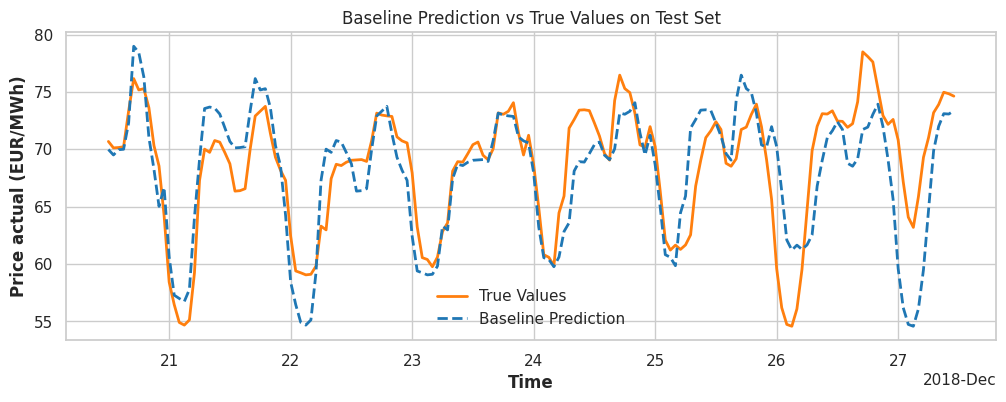

In [78]:
# plot
plt.figure(figsize=(12,4))
y_price_test_actual[-24*7:].plot(label='True Values', color='tab:orange')
y_price_test_pred_b[-24*7:].plot(label='Baseline Prediction', color='tab:blue', linestyle='--')
plt.legend()
plt.title('Baseline Prediction vs True Values on Test Set')
plt.xlabel('Time')
plt.ylabel('Price actual (EUR/MWh)')

#### 3.1.2 XGBoost

##### 3.1.2.1 Training

In [79]:
future_cols = known_cols + seasonal_lag_cols
past_cols = [c for c in df.columns.tolist() if c not in ['price actual'] + future_cols + lstm_shifted_known_cols] # exclue shifted known cols used only for blocked lstm
print(f"future_cols: {future_cols}")
print(f"past_cols: {past_cols}")

future_cols: ['temp_mean', 'temp_min', 'temp_max', 'temp_range', 'temp_rolling_mean_24', 'pressure_mean', 'wind_speed_mean', 'wind_speed_max', 'humidity_mean', 'clouds_all_mean', 'clouds_heavy_frac', 'rain_1h_mean', 'rain_1h_any', 'rain_sum24', 'is_weekend', 'is_holiday', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'price_actual_lag_24', 'total_load_actual_lag_24', 'price_actual_lag_25', 'total_load_actual_lag_25', 'price_actual_lag_48', 'total_load_actual_lag_48', 'price_actual_lag_168', 'total_load_actual_lag_168']
past_cols: ['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'forecast sola

In [80]:
# generate darts TimeSeries datasets
def mk_ts_block(d, target_cols=target_cols, past_cols=past_cols, future_cols=future_cols):
    y   = TimeSeries.from_dataframe(d, value_cols=target_cols)
    pst = TimeSeries.from_dataframe(d[past_cols])
    if future_cols:
        fut = TimeSeries.from_dataframe(d, value_cols=future_cols)
        return y, pst, fut
    else:
        return y, pst

y_tr_xgb,  past_tr_xgb, fut_tr_xgb  = mk_ts_block(train_df, target_cols=target_cols, past_cols=past_cols, future_cols=future_cols)
y_val_xgb, past_val_xgb, fut_val_xgb  = mk_ts_block(val_df,  target_cols=target_cols, past_cols=past_cols, future_cols=future_cols)
y_te_xgb,  past_te_xgb, fut_te_xgb  = mk_ts_block(test_df,  target_cols=target_cols, past_cols=past_cols, future_cols=future_cols)

In [81]:
ctx_y_xgb = y_tr_xgb.append(y_val_xgb)
ctx_p_xgb = past_tr_xgb.append(past_val_xgb)
ctx_f_xgb = fut_tr_xgb.append(fut_val_xgb)

def align_start(ts, t0, hour):
    for t in ts.time_index:
        if t >= t0 and t.hour == hour:
            return t
    return t0


lags_target = [-1, -2, -3, -12, -24, -48, -168]                    
lags_past   = [-1, -2, -3, -12, -24, -48, -168]                     
lags_fut = {
    "default_lags": list(range(0, 2 * H)),
    **{col: list(range(0, H)) for col in seasonal_lag_cols}
}

In [82]:
# We use a subset of the context data for hyperparameter optimization to speed up the process.
SUB_LEN = 24*365*2  # last 2 years

ctx_y_sub = ctx_y_xgb[-SUB_LEN:]
ctx_p_sub = ctx_p_xgb[-SUB_LEN:]
ctx_f_sub = ctx_f_xgb[-SUB_LEN:]


y_tr_sub   = ctx_y_sub[:-H*40]   
y_val_sub  = ctx_y_sub[-H*40:]
past_tr_sub= ctx_p_sub[:-H*40]
past_val_sub=ctx_p_sub[-H*40:]
fut_tr_sub = ctx_f_sub[:-H*40]
fut_val_sub= ctx_f_sub[-H*40:]

min_delta = 1e-4

def build_xgb_model(trial):
    # ------- fine-tune hyperparameters -------
    learning_rate   = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    max_depth       = trial.suggest_int("max_depth", 3, 8)
    min_child_weight= trial.suggest_float("min_child_weight", 1.0, 10.0)
    subsample       = trial.suggest_float("subsample", 0.6, 1.0)
    colsample_bt    = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    reg_lambda      = trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True)
    reg_alpha       = trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True)
    gamma           = trial.suggest_float("gamma", 0.0, 5.0)

    # ------- Darts XGBModel -------
    xgb_model = XGBModel(
        # Darts params
        lags=lags_target,
        lags_past_covariates=lags_past,
        lags_future_covariates=lags_fut,
        output_chunk_length=H,
        multi_models=True, 

        # To XGBRegressor
        objective="reg:squarederror",
        n_estimators=300,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bt,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        gamma=gamma,
        tree_method="hist",
        device="cuda",          
        random_state=42,
        eval_metric="rmse",

        callbacks=[
            xgb.callback.EarlyStopping(
                rounds=30,
                min_delta=min_delta,
                save_best=True
            )
        ],
    )

    return xgb_model

def objective(trial):
    xgb_model = build_xgb_model(trial)

    try:
        xgb_model.fit(
            series=y_tr_sub,
            past_covariates=past_tr_sub,
            future_covariates=fut_tr_sub,
            val_series=y_val_sub,
            val_past_covariates=past_val_sub,
            val_future_covariates=fut_val_sub,
            verbose=False,
        )
        best_iter = xgb_model.model.best_iteration
        trial.set_user_attr("best_iters_mean", best_iter)

        score = xgb_model.backtest(
            series=ctx_y_sub,
            past_covariates=ctx_p_sub,
            future_covariates=ctx_f_sub,
            start=val_start,           
            forecast_horizon=H,
            stride=H,
            metric=rmse,              
            reduction=np.mean,
            last_points_only=False,
            retrain=False,
            verbose=False,
        )
        return score

    finally:
        del xgb_model

sampler = optuna.samplers.TPESampler(
    seed=42,
    n_startup_trials=5,
    multivariate=True,
    group=True,
)

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=20,    
    n_warmup_steps=5,       
    interval_steps=1,
)

storage = "sqlite:///optuna_xgb_price_v1.db"

study = optuna.create_study(
    direction="minimize",
    study_name="study_xgb_price_v1",
    storage=storage,
    load_if_exists=True,
    sampler=sampler,
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=30, # increase for better results
    timeout=None,
    n_jobs=1,
)

print("Best params:", study.best_trial.params)
print("Best RMSE:", study.best_value)


[I 2025-11-16 19:12:14,759] A new study created in RDB with name: study_xgb_price_v1
[I 2025-11-16 19:13:43,822] Trial 0 finished with value: 4.512435436248779 and parameters: {'learning_rate': 0.005611516415334507, 'max_depth': 8, 'min_child_weight': 7.587945476302646, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_lambda': 0.029375384576328288, 'reg_alpha': 0.0014936568554617625, 'gamma': 4.330880728874676}. Best is trial 0 with value: 4.512435436248779.
[I 2025-11-16 19:14:51,994] Trial 1 finished with value: 4.009217739105225 and parameters: {'learning_rate': 0.015930522616241012, 'max_depth': 7, 'min_child_weight': 1.185260448662222, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'reg_lambda': 0.04335281794951567, 'reg_alpha': 0.0035113563139704067, 'gamma': 0.9170225492671691}. Best is trial 1 with value: 4.009217739105225.
[I 2025-11-16 19:15:35,733] Trial 2 finished with value: 5.09377384185791 and parameters: {'learning_

Best params: {'learning_rate': 0.047663079566114125, 'max_depth': 7, 'min_child_weight': 3.3862380404290584, 'subsample': 0.8330490147952825, 'colsample_bytree': 0.9787488766308301, 'reg_lambda': 0.035061193361798436, 'reg_alpha': 0.0024061564102637193, 'gamma': 4.0269670366519374}
Best RMSE: 3.869938373565674


In [83]:
# Load the best trial's parameters from the study
storage = "sqlite:///optuna_xgb_price_v1.db"
study = optuna.load_study(
    study_name="study_xgb_price_v1",
    storage=storage,
)
xgb_best_params = study.best_trial.params
print("Best params:", xgb_best_params)

Best params: {'learning_rate': 0.047663079566114125, 'max_depth': 7, 'min_child_weight': 3.3862380404290584, 'subsample': 0.8330490147952825, 'colsample_bytree': 0.9787488766308301, 'reg_lambda': 0.035061193361798436, 'reg_alpha': 0.0024061564102637193, 'gamma': 4.0269670366519374}


In [84]:
# Plot optimization history
fig = ov.plot_parallel_coordinate(
    study,
)
fig.show()

In [85]:
# Plot param importance to see which hyperparameters matter most
fig = ov.plot_param_importances(study) 
fig.show()

In [86]:
# Plot optimization history to see how the study progressed over trials
fig = ov.plot_optimization_history(study)
fig.show()

In [87]:
# ------- Train XGBModel with the best hyperparameters on the full training data -------
xgb_tv_model = XGBModel(
    # Darts
    lags=lags_target,
    lags_past_covariates=lags_past,
    lags_future_covariates=lags_fut,
    output_chunk_length=H,
    multi_models=True, 

    # To XGBRegressor
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=xgb_best_params['max_depth'],
    min_child_weight=xgb_best_params['min_child_weight'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    reg_lambda=xgb_best_params['reg_lambda'],
    reg_alpha=xgb_best_params['reg_alpha'],
    gamma=xgb_best_params['gamma'],
    tree_method="hist",
    device="cuda",                  
    random_state=42,
    eval_metric="rmse",

    callbacks=[
        xgb.callback.EarlyStopping(
            rounds=50,
            min_delta=min_delta,
            save_best=True
        )
    ],
)

xgb_tv_model.fit(
    series=y_tr_xgb,
    past_covariates=past_tr_xgb,
    future_covariates=fut_tr_xgb,
    val_series=y_val_xgb,
    val_past_covariates=past_val_xgb,
    val_future_covariates=fut_val_xgb,
    verbose=True,
)

[0]	validation_0-rmse:11.99154
[1]	validation_0-rmse:11.50411
[2]	validation_0-rmse:11.04146
[3]	validation_0-rmse:10.60564
[4]	validation_0-rmse:10.19632
[5]	validation_0-rmse:9.81186
[6]	validation_0-rmse:9.44382
[7]	validation_0-rmse:9.09790
[8]	validation_0-rmse:8.77156
[9]	validation_0-rmse:8.47029
[10]	validation_0-rmse:8.18125
[11]	validation_0-rmse:7.91404
[12]	validation_0-rmse:7.66403
[13]	validation_0-rmse:7.42695
[14]	validation_0-rmse:7.20166
[15]	validation_0-rmse:6.98849
[16]	validation_0-rmse:6.79020
[17]	validation_0-rmse:6.60510
[18]	validation_0-rmse:6.43125
[19]	validation_0-rmse:6.27143
[20]	validation_0-rmse:6.12116
[21]	validation_0-rmse:5.98164
[22]	validation_0-rmse:5.85068
[23]	validation_0-rmse:5.72927
[24]	validation_0-rmse:5.61234
[25]	validation_0-rmse:5.50470
[26]	validation_0-rmse:5.40684
[27]	validation_0-rmse:5.31472
[28]	validation_0-rmse:5.22973
[29]	validation_0-rmse:5.15035
[30]	validation_0-rmse:5.07479
[31]	validation_0-rmse:5.00598
[32]	validati

XGBModel(lags=[-1, -2, -3, -12, -24, -48, -168], lags_past_covariates=[-1, -2, -3, -12, -24, -48, -168], lags_future_covariates={'default_lags': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], 'price_actual_lag_24': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'total_load_actual_lag_24': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'price_actual_lag_25': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'total_load_actual_lag_25': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'price_actual_lag_48': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'total_load_actual_lag_48': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,

##### 3.1.2.2 Backtest

In [88]:
pred_val_xgb = xgb_tv_model.historical_forecasts(
    series=ctx_y_xgb,            # context + the period you want to evaluate
    past_covariates=ctx_p_xgb,  # updated past covariates
    future_covariates=ctx_f_xgb,  # updated future covariates
    start=val_start,             # begin forecasting at the first val issue time
    forecast_horizon=24,
    stride=24,                            # one forecast per day
    last_points_only=False,               # returns a full TimeSeries aligned to truth
    retrain=False,                        # fast evaluation; set True if you want refits
    verbose=False,
)

pred_val_xgb_flat = pred_val_xgb[0]
for b in pred_val_xgb[1:]:
    pred_val_xgb_flat = pred_val_xgb_flat.append(b)
pred_val_xgb_on = pred_val_xgb_flat.slice(val_start, val_end)

# mae
mae_val_xgb = mae(pred_val_xgb_on, y_price_val_actual)
rmse_val_xgb = rmse(pred_val_xgb_on, y_price_val_actual)
print(f"XGBoost MAE on val set: {mae_val_xgb:.4f}")
print(f"XGBoost RMSE on val set: {rmse_val_xgb:.4f}")


XGBoost MAE on val set: 3.1325
XGBoost RMSE on val set: 4.1937


In [89]:
print("Best iteration per sub-model:", xgb_tv_model.model.best_iteration)

Best iteration per sub-model: 837


##### 3.1.2.3 Feature Importance

In [90]:
lagged_feature_names = xgb_tv_model._lagged_feature_names
n_feat = len(lagged_feature_names)

model = next(iter(xgb_tv_model.models.values())) if hasattr(xgb_tv_model, "models") and isinstance(xgb_tv_model.models, dict) else xgb_tv_model.model
booster = model.get_booster() if hasattr(model, "get_booster") else model.booster_
sc = booster.get_score(importance_type="gain") 

imp = np.zeros(n_feat, dtype=float)
for k, v in sc.items():
    imp[int(k[1:])] = v  

fe_im = pd.Series(imp, index=lagged_feature_names, name="gain").sort_values(ascending=False)

# move the index into a column called 'feature'
fe_im_df = fe_im.rename_axis("feature").reset_index()

In [91]:
fe_im_df.head(100)

feature          gain
0        price_actual_lag_24_futcov_lag13  79279.085938
1         price_actual_lag_25_futcov_lag6  56247.738281
2         price_actual_lag_25_futcov_lag3  46880.816406
3        price_actual_lag_24_futcov_lag23  38335.183594
4        price_actual_lag_25_futcov_lag15  38194.386719
5               price actual_target_lag-1  27558.998047
6         price_actual_lag_25_futcov_lag7  25994.679688
7    price_actual_rw_3_mean_pastcov_lag-3  24752.066406
8    price_actual_rw_3_mean_pastcov_lag-2  23341.501953
9        price_actual_lag_24_futcov_lag10  22609.410156
10   price_actual_rw_3_mean_pastcov_lag-1  22294.941406
11       price_actual_lag_24_futcov_lag19  21300.511719
12       price_actual_lag_24_futcov_lag18  19596.716797
13        price_actual_lag_24_futcov_lag9  19499.255859
14  price_actual_rw_3_mean_pastcov_lag-12  19464.939453
15        price_actual_lag_24_futcov_lag8  19118.025391
16        price_actual_lag_24_futcov_lag7  17812.964844
17       price_actual_lag_24_futcov_lag17  17462.134766
18       price_actual_lag_24_futcov_lag15  16937.529297
19       price_actual_lag_25_futcov_lag14  16786.455078
20             price actual_target_lag-12  16752.777344
21       price_actual_lag_24_futcov_lag16  16734.640625
22        price_actual_lag_24_futcov_lag6  16424.585938
23        price_actual_lag_24_futcov_lag3  15641.488281
24       price_actual_lag_24_futcov_lag14  15238.749023
25       price_actual_lag_24_futcov_lag20  14363.494141
26       price_actual_lag_25_futcov_lag21  13967.387695
27        price_actual_lag_25_futcov_lag5  13953.912109
28  price_actual_rw_24_mean_pastcov_lag-1  13658.000000
29        price_actual_lag_24_futcov_lag2  13366.545898
30        price_actual_lag_24_futcov_lag5  13250.022461
31       price_actual_lag_24_futcov_lag11  12833.839844
32              price actual_target_lag-2  10482.521484
33              price actual_target_lag-3   9999.266602
34       price_actual_lag_25_futcov_lag22   7352.708496
35                  hour_cos_futcov_lag26   7217.256836
36             dayofweek_cos_futcov_lag13   5647.233398
37             dayofweek_cos_futcov_lag12   5571.481934
38              dayofweek_cos_futcov_lag9   5438.096680
39              dayofweek_cos_futcov_lag2   5244.946289
40             dayofweek_cos_futcov_lag11   5203.652344
41       price_actual_lag_168_futcov_lag4   5046.396484
42             dayofweek_cos_futcov_lag15   5040.902832
43             dayofweek_cos_futcov_lag18   4950.219238
44             dayofweek_cos_futcov_lag10   4903.233887
45              dayofweek_cos_futcov_lag8   4903.165527
46       price_actual_lag_24_futcov_lag22   4839.510742
47       price_actual_lag_168_futcov_lag2   4725.324707
48              dayofweek_cos_futcov_lag0   4695.746582
49       price_actual_lag_25_futcov_lag13   4623.324219
50             dayofweek_cos_futcov_lag16   4432.333496
51       price_actual_lag_168_futcov_lag3   4397.030762
52                is_weekend_futcov_lag13   4388.486328
53                is_weekend_futcov_lag18   4320.517090
54                is_weekend_futcov_lag11   4307.824219
55             dayofweek_cos_futcov_lag14   4234.666992
56             dayofweek_cos_futcov_lag19   4230.889648
57      price_actual_lag_168_futcov_lag12   4224.318359
58   price_actual_rw_6_mean_pastcov_lag-3   4217.435059
59      price_actual_lag_168_futcov_lag17   4185.577148
60              dayofweek_cos_futcov_lag7   4153.731934
61       price_actual_lag_168_futcov_lag8   4066.921875
62      price_actual_lag_168_futcov_lag10   4059.385498
63              dayofweek_cos_futcov_lag4   4045.177490
64                is_weekend_futcov_lag10   4034.657959
65                is_weekend_futcov_lag19   4034.617676
66      price_actual_lag_168_futcov_lag16   4018.158447
67      price_actual_lag_168_futcov_lag20   4000.680664
68       price_actual_lag_168_futcov_lag9   3966.805664
69                is_weekend_futcov_lag12   3966.542236
70      price_actual_lag_168_futcov_lag13   3962.109131
71

In [92]:
fe_im_df.tail(100)

feature       gain
1512      price_actual_rw_3_std_pastcov_lag-12  29.589233
1513                  rain_1h_any_futcov_lag41  29.048449
1514                   rain_1h_any_futcov_lag3  28.557386
1515                  rain_1h_any_futcov_lag34  28.493006
1516       price_actual_rw_3_std_pastcov_lag-3  27.887739
1517                     hour_cos_futcov_lag33  27.678391
1518          price_actual_lag_25_futcov_lag12  27.239277
1519       price_actual_rw_3_std_pastcov_lag-2  27.013571
1520                   rain_1h_any_futcov_lag8  26.512339
1521  total_load_actual_rw_3_std_pastcov_lag-3  26.330057
1522                  rain_1h_any_futcov_lag23  24.720093
1523                   rain_1h_any_futcov_lag4  24.102180
1524                    month_sin_futcov_lag41  24.089159
1525                   rain_1h_any_futcov_lag6  23.820810
1526                  rain_1h_any_futcov_lag37  19.955479
1527                  rain_1h_any_futcov_lag15  17.948311
1528                  rain_1h_any_futcov_lag36  16.466509
1529                     hour_cos_futcov_lag36  15.522079
1530                  rain_1h_any_futcov_lag20  15.447856
1531                   rain_1h_any_futcov_lag5  15.052248
1532                   rain_1h_any_futcov_lag1  14.852396
1533                  rain_1h_any_futcov_lag24  14.138666
1534                   rain_1h_any_futcov_lag9  14.134608
1535                  rain_1h_any_futcov_lag26  13.733488
1536                  rain_1h_any_futcov_lag33  12.527273
1537                  rain_1h_any_futcov_lag46  12.480403
1538                     hour_cos_futcov_lag37  12.309822
1539                  rain_1h_any_futcov_lag27  10.821629
1540                  rain_1h_any_futcov_lag32  10.153089
1541                  rain_1h_any_futcov_lag39   9.856556
1542                  rain_1h_any_futcov_lag40   9.036825
1543                  rain_1h_any_futcov_lag31   8.749617
1544                   rain_1h_any_futcov_lag7   8.140070
1545                  rain_1h_any_futcov_lag16   7.748163
1546                     hour_sin_futcov_lag16   7.058008
1547                  rain_1h_any_futcov_lag35   6.497812
1548                  rain_1h_any_futcov_lag28   5.501200
1549                   rain_1h_any_futcov_lag0   5.315687
1550                      hour_cos_futcov_lag9   0.000000
1551                     hour_sin_futcov_lag28   0.000000
1552                     hour_cos_futcov_lag16   0.000000
1553                  rain_1h_any_futcov_lag29   0.000000
1554                     hour_sin_futcov_lag29   0.000000
1555                      hour_sin_futcov_lag9   0.000000
1556                     hour_sin_futcov_lag11   0.000000
1557                     hour_cos_futcov_lag19   0.000000
1558                     hour_sin_futcov_lag31   0.000000
1559                     hour_cos_futcov_lag31   0.000000
1560                     hour_cos_futcov_lag28   0.000000
1561                     hour_cos_futcov_lag29   0.000000
1562                     hour_sin_futcov_lag36   0.000000
1563                     hour_sin_futcov_lag19   0.000000
1564                      hour_sin_futcov_lag4   0.000000
1565      total_load_actual_lag_25_futcov_lag1   0.000000
1566                      hour_cos_futcov_lag1   0.000000
1567           price_actual_lag_25_futcov_lag1   0.000000
1568                     hour_cos_futcov_lag21   0.000000
1569                     hour_sin_futcov_lag21   0.000000
1570                      hour_sin_futcov_lag1   0.000000
1571                      hour_cos_futcov_lag4   0.000000
1572                     hour_cos_futcov_lag30   0.000000
1573                     hour_sin_futcov_lag30   0.000000
1574                     hour_cos_futcov_lag47   0.000000
1575                     hour_sin_futcov_lag47   0.000000
1576                     hour_cos_futcov_lag17   0.000000
1577                     hour_sin_futcov_lag17   0.000000
1578                     hour_cos_futcov_lag32   0.000000
1579                     hour_sin_futcov_lag32   0.000000
1580                     hour_sin_fut

### 3.1.3 LSTM

In [93]:
df.columns.tolist()

['generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'forecast solar day ahead',
 'forecast wind onshore day ahead',
 'total load actual',
 'price actual',
 'temp_mean',
 'temp_min',
 'temp_max',
 'temp_range',
 'temp_rolling_mean_24',
 'pressure_mean',
 'wind_speed_mean',
 'wind_speed_max',
 'humidity_mean',
 'clouds_all_mean',
 'clouds_heavy_frac',
 'rain_1h_mean',
 'rain_1h_any',
 'rain_sum24',
 'is_weekend',
 'is_holiday',
 'hour_sin',
 'hour_cos',
 'dayofweek_sin',
 'dayofweek_cos',
 'month_sin',
 'month_cos',
 'price_actual_lag_24',
 'total_load_actual_lag_24',
 'price_actual_lag_25',
 'total_load_actual_lag_25',


In [94]:
drop_cols = [c for c in df.columns.tolist() if 'cloud' in c or 'rain' in c or 'hydro' in c or 'humidity' in c or 'temp' in c]

org_time_cols = ['is_weekend',
                 'is_holiday',
                 'hour_sin',
                 'hour_cos',
                 'dayofweek_sin',
                 'dayofweek_cos',
                 'month_sin',
                 'month_cos',
                 ]
rest_cols = [c for c in df.columns.tolist() if c not in drop_cols + org_time_cols ]

In [95]:
keep_cols = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation waste',
    'generation wind onshore',
    'forecast solar day ahead',
    'forecast wind onshore day ahead',
    'total load actual',
    'price actual',
    'pressure_mean',
    'wind_speed_mean',
    'wind_speed_max',
    'price_actual_lag_24',
    'total_load_actual_lag_24',
    'price_actual_lag_25',
    'total_load_actual_lag_25',
    'price_actual_lag_48',
    'total_load_actual_lag_48',
    'price_actual_lag_168',
    'total_load_actual_lag_168',
    'total_load_actual_rw_3_mean',
    'price_actual_rw_3_mean',
    'total_load_actual_rw_3_std',
    'price_actual_rw_3_std',
    'total_load_actual_rw_6_mean',
    'price_actual_rw_6_mean',
    'total_load_actual_rw_6_std',
    'price_actual_rw_6_std',
    'total_load_actual_rw_12_mean',
    'price_actual_rw_12_mean',
    'total_load_actual_rw_12_std',
    'price_actual_rw_12_std',
    'total_load_actual_rw_24_mean',
    'price_actual_rw_24_mean',
    'total_load_actual_rw_24_std',
    'price_actual_rw_24_std',
    'total_load_actual_rw_168_mean',
    'price_actual_rw_168_mean',
    'total_load_actual_rw_168_std',
    'price_actual_rw_168_std',
    'total_load_actual_diff_3',
    'price_actual_diff_3',
    'total_load_actual_diff_12',
    'price_actual_diff_12',
    'total_load_actual_diff_24',
    'price_actual_diff_24',
    'total_load_actual_diff_168',
    'price_actual_diff_168',
    'share_wind',
    'share_solar',
    'share_fossil',
    'share_other_ren',
    'share_nuclear',
    'pressure_mean_shifted',
    'wind_speed_mean_shifted',
    'wind_speed_max_shifted',
    'is_weekend_shifted',
    'is_holiday_shifted',
    'hour_sin_shifted',
    'hour_cos_shifted',
    'dayofweek_sin_shifted',
    'dayofweek_cos_shifted',
    'month_sin_shifted',
    'month_cos_shifted'
]

In [96]:
lstm_cols = [c for c in keep_cols if c not in ['price actual']]

In [97]:
# from darts import TimeSeries
def mk_ts_block(d):
    y   = TimeSeries.from_dataframe(d, value_cols=target_cols)
    pst = TimeSeries.from_dataframe(d[lstm_cols])
    return y, pst

y_tr_lstm,  past_tr_lstm  = mk_ts_block(train_df)
y_val_lstm, past_val_lstm  = mk_ts_block(val_df)
y_te_lstm,  past_te_lstm  = mk_ts_block(test_df)


sc_y = Scaler(scaler=StandardScaler())
sc_p = Scaler(scaler=StandardScaler())

y_tr_lstm_s    = sc_y.fit_transform(y_tr_lstm)
past_tr_lstm_s = sc_p.fit_transform(past_tr_lstm)

y_val_lstm_s    = sc_y.transform(y_val_lstm)
past_val_lstm_s = sc_p.transform(past_val_lstm)

y_te_lstm_s     = sc_y.transform(y_te_lstm)
past_te_lstm_s  = sc_p.transform(past_te_lstm)

In [98]:
dloader_kwargs = {"num_workers": 5, "pin_memory": True, "persistent_workers": True}

torch.set_float32_matmul_precision("high") 

ctx_y_lstm = y_tr_lstm_s.append(y_val_lstm_s)
ctx_p_lstm = past_tr_lstm_s.append(past_val_lstm_s)

In [101]:
# Here we don't use the subset, instead, we use the full context for better evaluation during hyperparameter tuning.

class OptunaPruningCallback(PyTorchLightningPruningCallback, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


def build_model(trial):
    W           = trial.suggest_categorical("W", [24, 48, 168])                
    hidden_dim  = trial.suggest_int("hidden_dim", 64, 256, step=64)
    n_layers    = trial.suggest_int("n_layers", 1, 3)
    dropout     = trial.suggest_float("dropout", 0.1, 0.4, step=0.1)        
    batch_size  = trial.suggest_categorical("batch_size", [64, 128, 256, 512])   
    lr          = trial.suggest_float("lr", 1e-4, 3e-3, log=True)          
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    grad_clip = trial.suggest_categorical("gradient_clip_val", [0.0, 0.1, 1.0])

    #run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
    #model_name = (f"optuna_dprice_{trial.number}_{run_id}_W{W}_hd{hidden_dim}_L{n_layers}_do{dropout}_bs{batch_size}_lr{lr:g}_wd{weight_decay:g}")

    early_stop = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=4)
    pl_pruning = OptunaPruningCallback(trial, monitor="val_loss")


    model = BlockRNNModel(
        model="LSTM",
        loss_fn=nn.SmoothL1Loss(beta=1.0), # Huber loss
        input_chunk_length=W,
        output_chunk_length=H,
        n_rnn_layers=n_layers,
        hidden_dim=hidden_dim,
        dropout=dropout,
        batch_size=batch_size,
        n_epochs=50,                                          
        optimizer_cls=torch.optim.AdamW,
        optimizer_kwargs={"lr": lr, "weight_decay": weight_decay},
        lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
        lr_scheduler_kwargs={"T_max": 40, "eta_min": 1e-5},   
        random_state=42,

        # shut off logging to speed up
        log_tensorboard=False,
        save_checkpoints=False,

        force_reset=True,
        pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": 1,
        "deterministic": False,
        "callbacks": [early_stop, pl_pruning],
        "gradient_clip_val": grad_clip},
    )

    return model

def objective(trial):
    model = build_model(trial)
    try:
        model.fit(
            series=y_tr_lstm_s, past_covariates=past_tr_lstm_s,
            val_series=y_val_lstm_s, val_past_covariates=past_val_lstm_s,
            dataloader_kwargs=dloader_kwargs,
            verbose=False,
        )

        score = model.backtest(
            series=ctx_y_lstm, 
            past_covariates=ctx_p_lstm,
            start=val_start, 
            forecast_horizon=H,
            stride=H,                 
            metric=mae,
            reduction=np.mean,        
            last_points_only=False,
            retrain=False,   
        )

        trial.set_user_attr("val_mae", float(score))
        return score
    finally:
        del model
        torch.cuda.empty_cache()


sampler = optuna.samplers.TPESampler(
    seed=42,
    n_startup_trials=10,    
    multivariate=True,     
    group=True,             
)

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=10,    
    n_warmup_steps=5,      
    interval_steps=1,      
)
storage = "sqlite:///optuna_block_lstm_v1.db"

study = optuna.create_study(
    direction="minimize",
    study_name="block_price_lstm_search_v1",
    storage=storage,
    load_if_exists=True,
    sampler=sampler,
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=25,      
    timeout=None,
    n_jobs=1,          
)

print("Best params:", study.best_trial.params)
print("Best MAE:", study.best_value)


[I 2025-11-16 19:59:35,815] A new study created in RDB with name: block_price_lstm_search_v1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-11-16 19:59:52,653] Trial 0 finished with value: 0.2854422926902771 and parameters: {'W': 48, 'hidden_dim': 192, 'n_layers': 1, 'dropout': 0.1, 'batch_size': 128, 'lr': 0.00010725209743172001, 'weight_decay': 0.008123245085588688, 'gradient_clip_val': 0.0}. Best is trial 0 with value: 0.2854422926902771.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2025-11-16 20:00:01,231] Trial 1 finished with value: 0.30078062415122986 and parameters: {'W': 168, '

Best params: {'W': 24, 'hidden_dim': 256, 'n_layers': 3, 'dropout': 0.4, 'batch_size': 256, 'lr': 0.00015144860262751404, 'weight_decay': 0.0003058656666978527, 'gradient_clip_val': 0.1}
Best MAE: 0.23338858783245087


In [102]:
# show optuna study results
print("Best params:", study.best_trial.params)
print("Best MAE:", study.best_value)
best_trial = study.best_trial
print("Best trial number:", best_trial.number)

Best params: {'W': 24, 'hidden_dim': 256, 'n_layers': 3, 'dropout': 0.4, 'batch_size': 256, 'lr': 0.00015144860262751404, 'weight_decay': 0.0003058656666978527, 'gradient_clip_val': 0.1}
Best MAE: 0.23338858783245087
Best trial number: 2


In [103]:
# plot parallel coordinate to visualize hyperparameter effects
fig = ov.plot_parallel_coordinate(
    study,
)
fig.show()

In [104]:
# plot param importance to see which hyperparameters matter most
fig = ov.plot_param_importances(study) 
fig.show()

In [105]:
# plot optimization history to see how the study progressed over trials
fig = ov.plot_optimization_history(study)
fig.show()

In [106]:
# load optuna study if skipped optuna tuning

storage = "sqlite:///optuna_block_lstm_v1.db"
study = optuna.load_study(
    study_name="block_price_lstm_search_v1",
    storage=storage,
)

study.best_trial.params


{'W': 24,
 'hidden_dim': 256,
 'n_layers': 3,
 'dropout': 0.4,
 'batch_size': 256,
 'lr': 0.00015144860262751404,
 'weight_decay': 0.0003058656666978527,
 'gradient_clip_val': 0.1}

In [107]:
best = study.best_trial.params
W         = best["W"]
hidden    = best["hidden_dim"]
n_layers  = best["n_layers"]
dropout   = best["dropout"]
batch_sz  = best["batch_size"]
lr        = best["lr"]
weight_decay = best["weight_decay"]
grad_clip = best["gradient_clip_val"]

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# We can fine tune the hyperparameters a bit more here if needed. Here, we keep useing the same ones.
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = (f"lstm_tv_{run_id}_W{W}_hd{hidden}_L{n_layers}_do{dropout}_bs{batch_sz}_lr{lr:g}_wd{weight_decay:g}")

early_stop = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=10)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

lstm_tv_model = BlockRNNModel(
    model="LSTM",
    loss_fn=nn.SmoothL1Loss(beta=1.0),
    input_chunk_length=W,
    output_chunk_length=H,
    n_rnn_layers=n_layers,
    hidden_dim=hidden,
    dropout=dropout,
    batch_size=batch_sz,
    n_epochs=20,                                           
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs={"lr": lr, "weight_decay": weight_decay},
    lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 40, "eta_min": 1e-4},   
    random_state=42,
    log_tensorboard=True,
    work_dir="./runs",
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
        "accelerator": "gpu", "devices": 1,
        "deterministic": False,
        "callbacks": [early_stop, lr_monitor],
        "gradient_clip_val": grad_clip,
        "log_every_n_steps": 20,
    },
)

ctx_y = y_tr_lstm_s.append(y_val_lstm_s)
ctx_p = past_tr_lstm_s.append(past_val_lstm_s)

lstm_tv_model.fit(
    series=y_tr_lstm_s, 
    past_covariates=past_tr_lstm_s,
    val_series=y_val_lstm_s, 
    val_past_covariates=past_val_lstm_s,
    dataloader_kwargs=dloader_kwargs,
    verbose=False
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=20` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=256, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.4, activation=ReLU, loss_fn=SmoothL1Loss(), input_chunk_length=24, output_chunk_length=24, batch_size=256, n_epochs=20, optimizer_cls=<class 'torch.optim.adamw.AdamW'>, optimizer_kwargs={'lr': 0.00015144860262751404, 'weight_decay': 0.0003058656666978527}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, lr_scheduler_kwargs={'T_max': 40, 'eta_min': 0.0001}, random_state=42, log_tensorboard=True, work_dir=./runs, model_name=lstm_tv_20251116-201308_W24_hd256_L3_do0.4_bs256_lr0.000151449_wd0.000305866, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'deterministic': False, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x71a013261b10>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x71a013261a50>], 'gradient_clip_val': 0.1, 'log_every_n_steps': 20})

In [ ]:
# lode the best model
best_lstm = BlockRNNModel.load_from_checkpoint(
    model_name=model_name,
    work_dir="./runs",
)

In [135]:
print("Val Forecast starting at:", val_start)

pred_val_lstm = best_lstm.historical_forecasts(
    series=ctx_y_lstm,
    past_covariates=ctx_p_lstm,
    start=val_start,
    forecast_horizon=H,
    stride=H,
    last_points_only=False,
    retrain=False,
    verbose=False,
)

pred_val_lstm_flat = pred_val_lstm[0]

for b in pred_val_lstm[1:]:
    pred_val_lstm_flat = pred_val_lstm_flat.append(b)
pred_val_lstm_flat_orig = sc_y.inverse_transform(pred_val_lstm_flat)


pred_val_lstm_on_orig = pred_val_lstm_flat_orig.slice(val_start, val_end)

mae(pred_val_lstm_on_orig, y_price_val_actual)
rmse(pred_val_lstm_on_orig, y_price_val_actual)

mae_lstm_val = mae(pred_val_lstm_on_orig, y_price_val_actual)
rmse_lstm_val = rmse(pred_val_lstm_on_orig, y_price_val_actual)
print("val lstm mae:", mae_lstm_val)
print("val lstm rmse:", rmse_lstm_val, )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Val Forecast starting at: 2018-10-29 12:00:00
val lstm mae: 3.459077
val lstm rmse: 4.5192084


### 3.4 Probabilistic Forecasting

#### 3.4.1 XGBoost

In [144]:
# ------- Train Probabilistic XGBModel with the best hyperparameters -------
QUANTILES = [0.05, 0.25, 0.5, 0.75, 0.95] 

xgb_prob_model = XGBModel(
    # Darts
    lags=lags_target,
    lags_past_covariates=lags_past,
    lags_future_covariates=lags_fut,
    output_chunk_length=H,
    multi_models=True,

    # To XGBRegressor
    likelihood="quantile",
    quantiles=QUANTILES,

    # XGB params
    n_estimators=1000,
    learning_rate=xgb_best_params["learning_rate"],
    max_depth=xgb_best_params["max_depth"],
    min_child_weight=xgb_best_params["min_child_weight"],
    subsample=xgb_best_params["subsample"],
    colsample_bytree=xgb_best_params["colsample_bytree"],
    reg_lambda=xgb_best_params["reg_lambda"],
    reg_alpha=xgb_best_params["reg_alpha"],
    gamma=xgb_best_params["gamma"],
    tree_method="hist",
    device="cuda",
    random_state=42,

    # objective will be covered by likelihood, can be omitted
    # eval_metric is not particularly important for quantile, can be removed or changed

    callbacks=[
        xgb.callback.EarlyStopping(
            rounds=50,
            min_delta=min_delta,
            save_best=True,
        )
    ],
)

xgb_prob_model.fit(
    series=y_tr_xgb,
    past_covariates=past_tr_xgb,
    future_covariates=fut_tr_xgb,
    val_series=y_val_xgb,
    val_past_covariates=past_val_xgb,
    val_future_covariates=fut_val_xgb,
    verbose=False,
)

XGBModel(lags=[-1, -2, -3, -12, -24, -48, -168], lags_past_covariates=[-1, -2, -3, -12, -24, -48, -168], lags_future_covariates={'default_lags': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], 'price_actual_lag_24': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'total_load_actual_lag_24': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'price_actual_lag_25': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'total_load_actual_lag_25': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'price_actual_lag_48': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'total_load_actual_lag_48': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,

In [175]:
est = xgb_prob_model.get_estimator(
    horizon=0,
    target_dim=0,
    quantile=0.5,
)
# best_iteration
est.best_iteration

335

In [149]:
# This will take a few minutes, to speed up, do not use num_samples or reduce it.
pred_tv_prob_xgb = xgb_prob_model.historical_forecasts(
    series= ctx_y_xgb,           
    past_covariates= ctx_p_xgb,  
    future_covariates= ctx_f_xgb,  
    start=val_start,            
    forecast_horizon=24,
    stride=24,                          
    last_points_only=False,             
    retrain=False,                       
    random_state=42,
    predict_likelihood_parameters=True
)

In [151]:
from darts.metrics import mae, rmse

b0 = pred_tv_prob_xgb[0]
pred_val_xgb_q05_flat  = b0.univariate_component(0)
pred_val_xgb_q25_flat  = b0.univariate_component(1)
pred_val_xgb_q50_flat  = b0.univariate_component(2)
pred_val_xgb_q75_flat  = b0.univariate_component(3)
pred_val_xgb_q95_flat  = b0.univariate_component(4)


for b in pred_tv_prob_xgb[1:]:
    pred_val_xgb_q05_flat  = pred_val_xgb_q05_flat.append(b.univariate_component(0))
    pred_val_xgb_q25_flat  = pred_val_xgb_q25_flat.append(b.univariate_component(1))
    pred_val_xgb_q50_flat  = pred_val_xgb_q50_flat.append(b.univariate_component(2))
    pred_val_xgb_q75_flat  = pred_val_xgb_q75_flat.append(b.univariate_component(3))
    pred_val_xgb_q95_flat  = pred_val_xgb_q95_flat.append(b.univariate_component(4))

y_true_val_xgb = y_price_val_actual.slice(val_start, val_end)
pred_val_xgb_q05_on = pred_val_xgb_q05_flat.slice(val_start, val_end)
pred_val_xgb_q25_on = pred_val_xgb_q25_flat.slice(val_start, val_end)
pred_val_xgb_q50_on = pred_val_xgb_q50_flat.slice(val_start, val_end)
pred_val_xgb_q75_on = pred_val_xgb_q75_flat.slice(val_start, val_end)
pred_val_xgb_q95_on = pred_val_xgb_q95_flat.slice(val_start, val_end)

# point forecast mae/rmse
mae_val_xgb_q50 = mae(y_true_val_xgb, pred_val_xgb_q50_on)
rmse_val_xgb_q50 = rmse(y_true_val_xgb, pred_val_xgb_q50_on)
print(f"XGB Quantile Model Validation MAE (q50): {mae_val_xgb_q50:.4f}")  
print(f"XGB Quantile Model Validation RMSE (q50): {rmse_val_xgb_q50:.4f}")  

# coverage 50% and 90%
y = y_true_val_xgb.values().flatten()
q05_xgb = pred_val_xgb_q05_on.values().flatten()
q25_xgb = pred_val_xgb_q25_on.values().flatten()
q50_xgb = pred_val_xgb_q50_on.values().flatten()
q75_xgb = pred_val_xgb_q75_on.values().flatten()
q95_xgb = pred_val_xgb_q95_on.values().flatten()

coverage_50_xgb = np.mean((y >= q25_xgb) & (y <= q75_xgb))
coverage_90_xgb = np.mean((y >= q05_xgb) & (y <= q95_xgb))

print(f"XGB Quantile Model Validation Coverage 50%: {coverage_50_xgb:.4f}")
print(f"XGB Quantile Model Validation Coverage 90%: {coverage_90_xgb:.4f}")


XGB Quantile Model Validation MAE (q50): 3.1168
XGB Quantile Model Validation RMSE (q50): 4.1772
XGB Quantile Model Validation Coverage 50%: 0.3707
XGB Quantile Model Validation Coverage 90%: 0.8951


#### 3.4.2 LSTM

In [116]:
qr = QuantileRegression(
    quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]   
)

# We can fine tune the hyperparameters a bit more here if needed. Here, we keep useing the same ones.
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = (f"lstm_tv_prob_{run_id}_W{W}_hd{hidden}_L{n_layers}_do{dropout}_bs{batch_sz}_lr{lr:g}_wd{weight_decay:g}")

early_stop = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=10)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

lstm_tv_prob_model = BlockRNNModel(
    model="LSTM",
    likelihood=qr,
    input_chunk_length=W,
    output_chunk_length=H,
    n_rnn_layers=n_layers,
    hidden_dim=hidden,
    dropout=dropout,
    batch_size=batch_sz,
    n_epochs=20,                                           
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs={"lr": lr, "weight_decay": weight_decay},
    lr_scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR,
    lr_scheduler_kwargs={"T_max": 40, "eta_min": 1e-5},   
    random_state=42,
    log_tensorboard=True,
    work_dir="./runs",
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    pl_trainer_kwargs={
        "accelerator": "gpu", "devices": 1, 
        "deterministic": False,
        "callbacks": [early_stop, lr_monitor],
        "gradient_clip_val": grad_clip,
        "log_every_n_steps": 20,
    },
)

ctx_y = y_tr_lstm_s.append(y_val_lstm_s)
ctx_p = past_tr_lstm_s.append(past_val_lstm_s)

lstm_tv_prob_model.fit(
    series=y_tr_lstm_s, 
    past_covariates=past_tr_lstm_s,
    val_series=y_val_lstm_s, 
    val_past_covariates=past_val_lstm_s,
    dataloader_kwargs=dloader_kwargs,
    verbose=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=256, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.4, activation=ReLU, likelihood=QuantileRegression(quantiles=[0.05, 0.25, 0.5, 0.75, 0.95], prior_strength=1.0), input_chunk_length=24, output_chunk_length=24, batch_size=256, n_epochs=20, optimizer_cls=<class 'torch.optim.adamw.AdamW'>, optimizer_kwargs={'lr': 0.00015144860262751404, 'weight_decay': 0.0003058656666978527}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, lr_scheduler_kwargs={'T_max': 40, 'eta_min': 1e-05}, random_state=42, log_tensorboard=True, work_dir=./runs, model_name=lstm_tv_prob_20251116-210838_W24_hd256_L3_do0.4_bs256_lr0.000151449_wd0.000305866, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': 1, 'deterministic': False, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x71a0137d9b10>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 

In [126]:
print("Forecast starting at:", val_start)

pred_val_lstm_prob = lstm_tv_prob_model.historical_forecasts(
    series=ctx_y_lstm,
    past_covariates=ctx_p_lstm,
    start=val_start,
    forecast_horizon=H,
    stride=H,
    last_points_only=False,  
    retrain=False,
    verbose=False,
    random_state=42,
    predict_likelihood_parameters=True
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Forecast starting at: 2018-10-29 12:00:00


In [129]:
# Comment in english

b0 = pred_val_lstm_prob[0]
lstm_q05_flat_s = b0.univariate_component(0)
lstm_q25_flat_s = b0.univariate_component(1)
lstm_q50_flat_s = b0.univariate_component(2)
lstm_q75_flat_s = b0.univariate_component(3)
lstm_q95_flat_s = b0.univariate_component(4)

for b in pred_val_lstm_prob[1:]:
    lstm_q05_flat_s = lstm_q05_flat_s.append(b.univariate_component(0))
    lstm_q25_flat_s = lstm_q25_flat_s.append(b.univariate_component(1))
    lstm_q50_flat_s = lstm_q50_flat_s.append(b.univariate_component(2))
    lstm_q75_flat_s = lstm_q75_flat_s.append(b.univariate_component(3))
    lstm_q95_flat_s = lstm_q95_flat_s.append(b.univariate_component(4))

pred_val_lstm_q05_flat_orig    = sc_y.inverse_transform(lstm_q05_flat_s)
pred_val_lstm_q25_flat_orig    = sc_y.inverse_transform(lstm_q25_flat_s)
pred_val_lstm_50_flat_orig = sc_y.inverse_transform(lstm_q50_flat_s)
pred_val_lstm_q75_flat_orig    = sc_y.inverse_transform(lstm_q75_flat_s)
pred_val_lstm_q95_flat_orig    = sc_y.inverse_transform(lstm_q95_flat_s)

pred_val_lstm_50_on_orig = pred_val_lstm_50_flat_orig.slice(val_start, val_end)
pred_val_lstm_q05_on_orig    = pred_val_lstm_q05_flat_orig.slice(val_start, val_end)
pred_val_lstm_q25_on_orig    = pred_val_lstm_q25_flat_orig.slice(val_start, val_end)
pred_val_lstm_q75_on_orig    = pred_val_lstm_q75_flat_orig.slice(val_start, val_end)
pred_val_lstm_q95_on_orig    = pred_val_lstm_q95_flat_orig.slice(val_start, val_end)

y_true_val = y_price_val_actual.slice(val_start, val_end)



In [ ]:
mae_lstm_prob_val  = mae(pred_val_lstm_50_on_orig, y_true_val) 
rmse_lstm_prob_val = rmse(pred_val_lstm_50_on_orig, y_true_val)

print("lstm (QR, q=0.5) val mae:", mae_lstm_prob_val)
print("lstm (QR, q=0.5) val rmse:", rmse_lstm_prob_val)

lstm (QR, q=0.5) val mae: 3.5962868
lstm (QR, q=0.5) val rmse: 4.700045


In [120]:
# coverage 50% and 90%
y_true_vals = y_true_val.values().flatten()
q05_vals_lstm   = pred_val_lstm_q05_on_orig.values().flatten()
q25_vals_lstm   = pred_val_lstm_q25_on_orig.values().flatten()
q75_vals_lstm    = pred_val_lstm_q75_on_orig.values().flatten()
q95_vals_lstm    = pred_val_lstm_q95_on_orig.values().flatten()

in_90_lstm      = (y_true_vals >= q05_vals_lstm) & (y_true_vals <= q95_vals_lstm)
coverage_90_lstm = in_90_lstm.mean()

in_50_lstm      = (y_true_vals >= q25_vals_lstm) & (y_true_vals <= q75_vals_lstm)
coverage_50_lstm = in_50_lstm.mean()

print(f"Validation (LSTM): Coverage 50% interval (q25–q75): {coverage_50_lstm:.3%}")
print(f"Validation (LSTM): Coverage 90% interval (q05–q95): {coverage_90_lstm:.3%}")


Validation (LSTM): Coverage 50% interval (q25–q75): 30.460%
Validation (LSTM): Coverage 90% interval (q05–q95): 67.385%


###  3.5. Validation Summary & Model Selection

In [152]:
# Summary of point forecasting results
print("Summary--point forecasting:")
print(f"Baseline - MAE: {mae_val_baseline:.4f}, RMSE: {rmse_bal_baseline:.4f}")
print(f"XGBoost - MAE: {mae_val_xgb:.4f}, RMSE: {rmse_val_xgb:.4f}")
print(f"XGBoost (QR, q=0.5) - MAE: {mae_val_xgb_q50:.4f}, RMSE: {rmse_val_xgb_q50:.4f}")
print(f"LSTM (Point) - MAE: {mae_lstm_val:.4f}, RMSE: {rmse_lstm_val:.4f}")
print(f"LSTM (QR, q=0.5) - MAE: {mae_lstm_prob_val:.4f}, RMSE: {rmse_lstm_prob_val:.4f}")

print()

# Summary of prob forecasting results
print(f"Summary--probabilistic forecasting:")
print(f"XGB (QR) - Coverage 50% interval (q25–q75): {coverage_50_xgb:.3%}")
print(f"LSTM (QR) - Coverage 50% interval (q25–q75): {coverage_50_lstm:.3%}")
print(f"XGB (QR) - Coverage 90% interval (q05–q95): {coverage_90_xgb:.3%}")
print(f"LSTM (QR) - Coverage 90% interval (q05–q95): {coverage_90_lstm:.3%}")

Summary--point forecasting:
Baseline - MAE: 4.9524, RMSE: 6.6013
XGBoost - MAE: 3.1325, RMSE: 4.1937
XGBoost (QR, q=0.5) - MAE: 3.1168, RMSE: 4.1772
LSTM (Point) - MAE: 3.4591, RMSE: 4.5192
LSTM (QR, q=0.5) - MAE: 3.5963, RMSE: 4.7000

Summary--probabilistic forecasting:
XGB (QR) - Coverage 50% interval (q25–q75): 37.069%
LSTM (QR) - Coverage 50% interval (q25–q75): 30.460%
XGB (QR) - Coverage 90% interval (q05–q95): 89.511%
LSTM (QR) - Coverage 90% interval (q05–q95): 67.385%


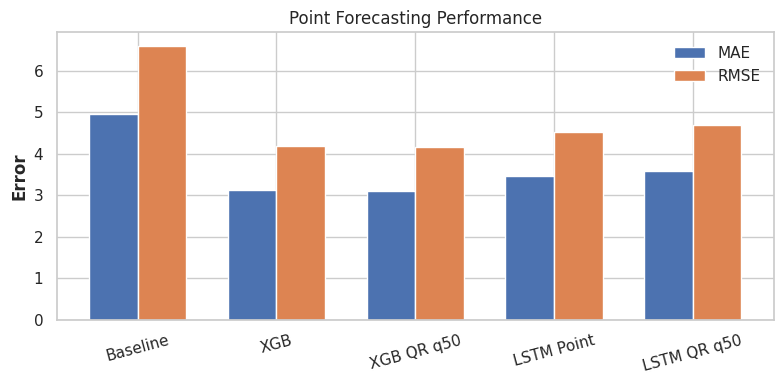

In [153]:
import numpy as np
import matplotlib.pyplot as plt

models = ["Baseline", "XGB", "XGB QR q50", "LSTM Point", "LSTM QR q50"]
mae = [mae_val_baseline, mae_val_xgb, mae_val_xgb_q50, mae_lstm_val, mae_lstm_prob_val]
rmse = [rmse_bal_baseline, rmse_val_xgb, rmse_val_xgb_q50, rmse_lstm_val, rmse_lstm_prob_val]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width/2, mae, width, label="MAE")
ax.bar(x + width/2, rmse, width, label="RMSE")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylabel("Error")
ax.set_title("Point Forecasting Performance")
ax.legend()
plt.tight_layout()
plt.show()


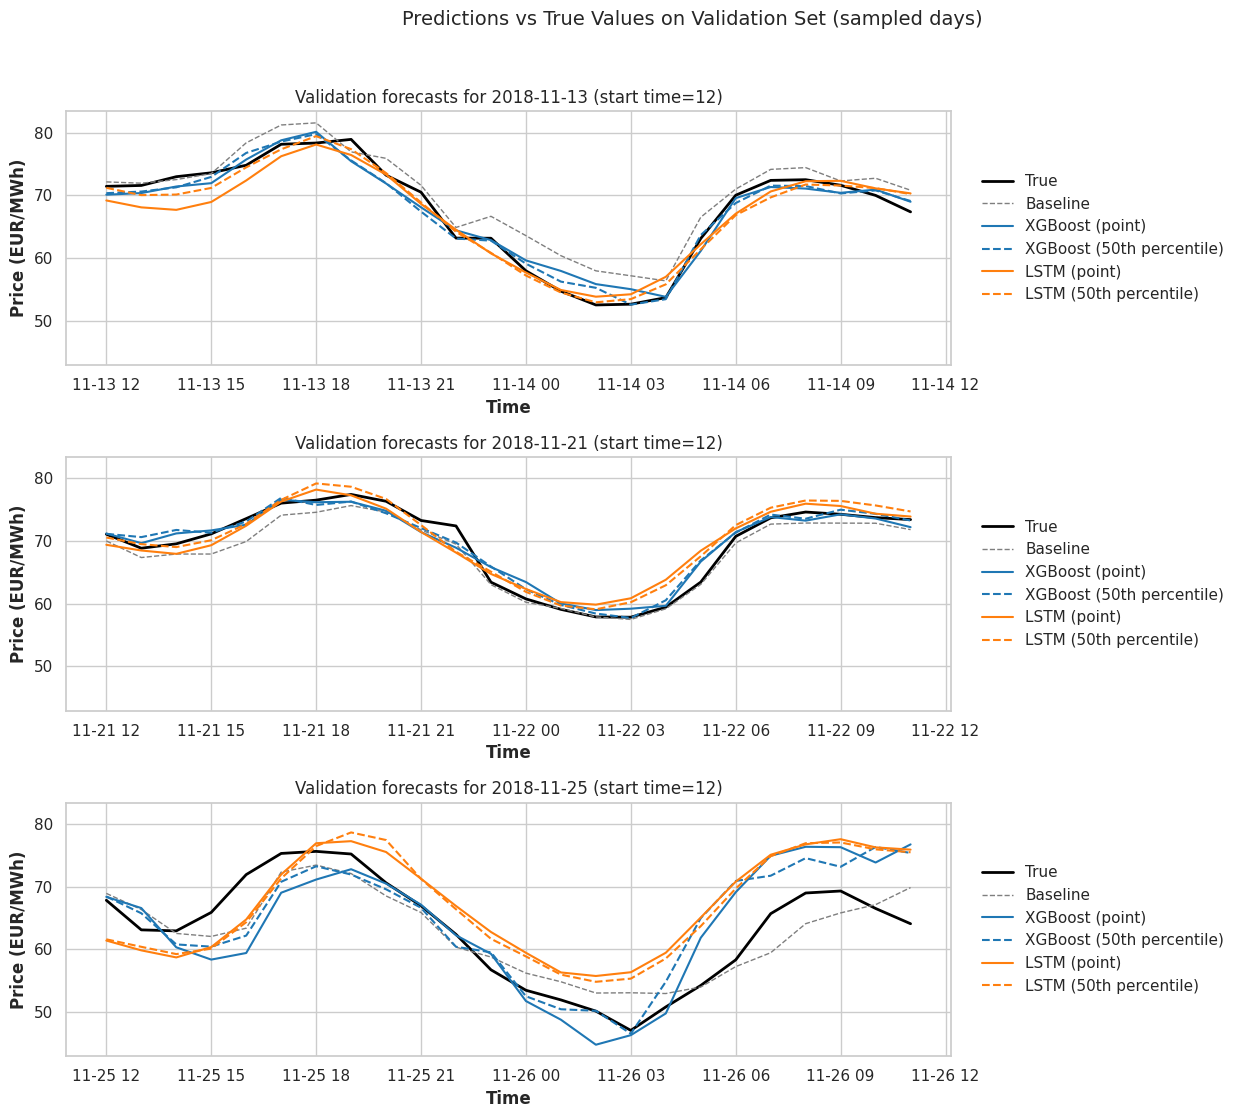

In [154]:
np.random.seed(42)
val_days = y_val_base.time_index.normalize().unique()
sampled_days = np.random.choice(val_days, size=3, replace=False)
sampled_days = np.sort(sampled_days)

# point forecasting on validation set - sampled days
fig, axes = plt.subplots(len(sampled_days), 1, figsize=(14, 12), sharey=True)
if len(sampled_days) == 1:
    axes = [axes]

for ax, day in zip(axes, sampled_days):
    start = day + pd.Timedelta(hours=ISSUE_HOUR)
    end = start + pd.Timedelta(hours=H-1)

    y_true = y_price_val_actual.slice(start, end)

    y_base = y_price_val_pred_b.slice(start, end)
    y_xgb  = pred_val_xgb_on.slice(start, end)
    y_xgb_q50 = pred_val_xgb_q50_on.slice(start, end)
    y_lstm = pred_val_lstm_on_orig.slice(start, end)
    y_lstm_q50 = pred_val_lstm_50_on_orig.slice(start, end)
    

    t = y_true.time_index

    ax.plot(t, y_true.values(),
            label="True",
            linewidth=2,
            color="black")

    ax.plot(t, y_base.values(),
            label="Baseline",
            linestyle="--",
            linewidth=1,
            color="tab:gray")

    ax.plot(t, y_xgb.values(),
            label="XGBoost (point)",
            linestyle="-",
            linewidth=1.5,
            color="tab:blue")
    
    ax.plot(t, y_xgb_q50.values(),
            label="XGBoost (50th percentile)",
            linestyle="--",
            linewidth=1.5,
            color="tab:blue")
    
    ax.plot(t, y_lstm.values(),
            label="LSTM (point)",
            linestyle="-",
            linewidth=1.5,
            color="tab:orange")
      
    ax.plot(t, y_lstm_q50.values(),
            label="LSTM (50th percentile)",
            linestyle="--",
            linewidth=1.5,
            color="tab:orange")  # Added LSTM (50th percentile) plot
    
    ax.set_title(f"Validation forecasts for {pd.Timestamp(day).date()} (start time={ISSUE_HOUR})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True)

    ax.legend(
        loc="center left",          
        bbox_to_anchor=(1.02, 0.5)
    )

axes[-1].set_xlabel("Time")
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle("Predictions vs True Values on Validation Set (sampled days)", fontsize=14)
fig.tight_layout(rect=[0, 0.05, 0.9, 0.96])

plt.show()

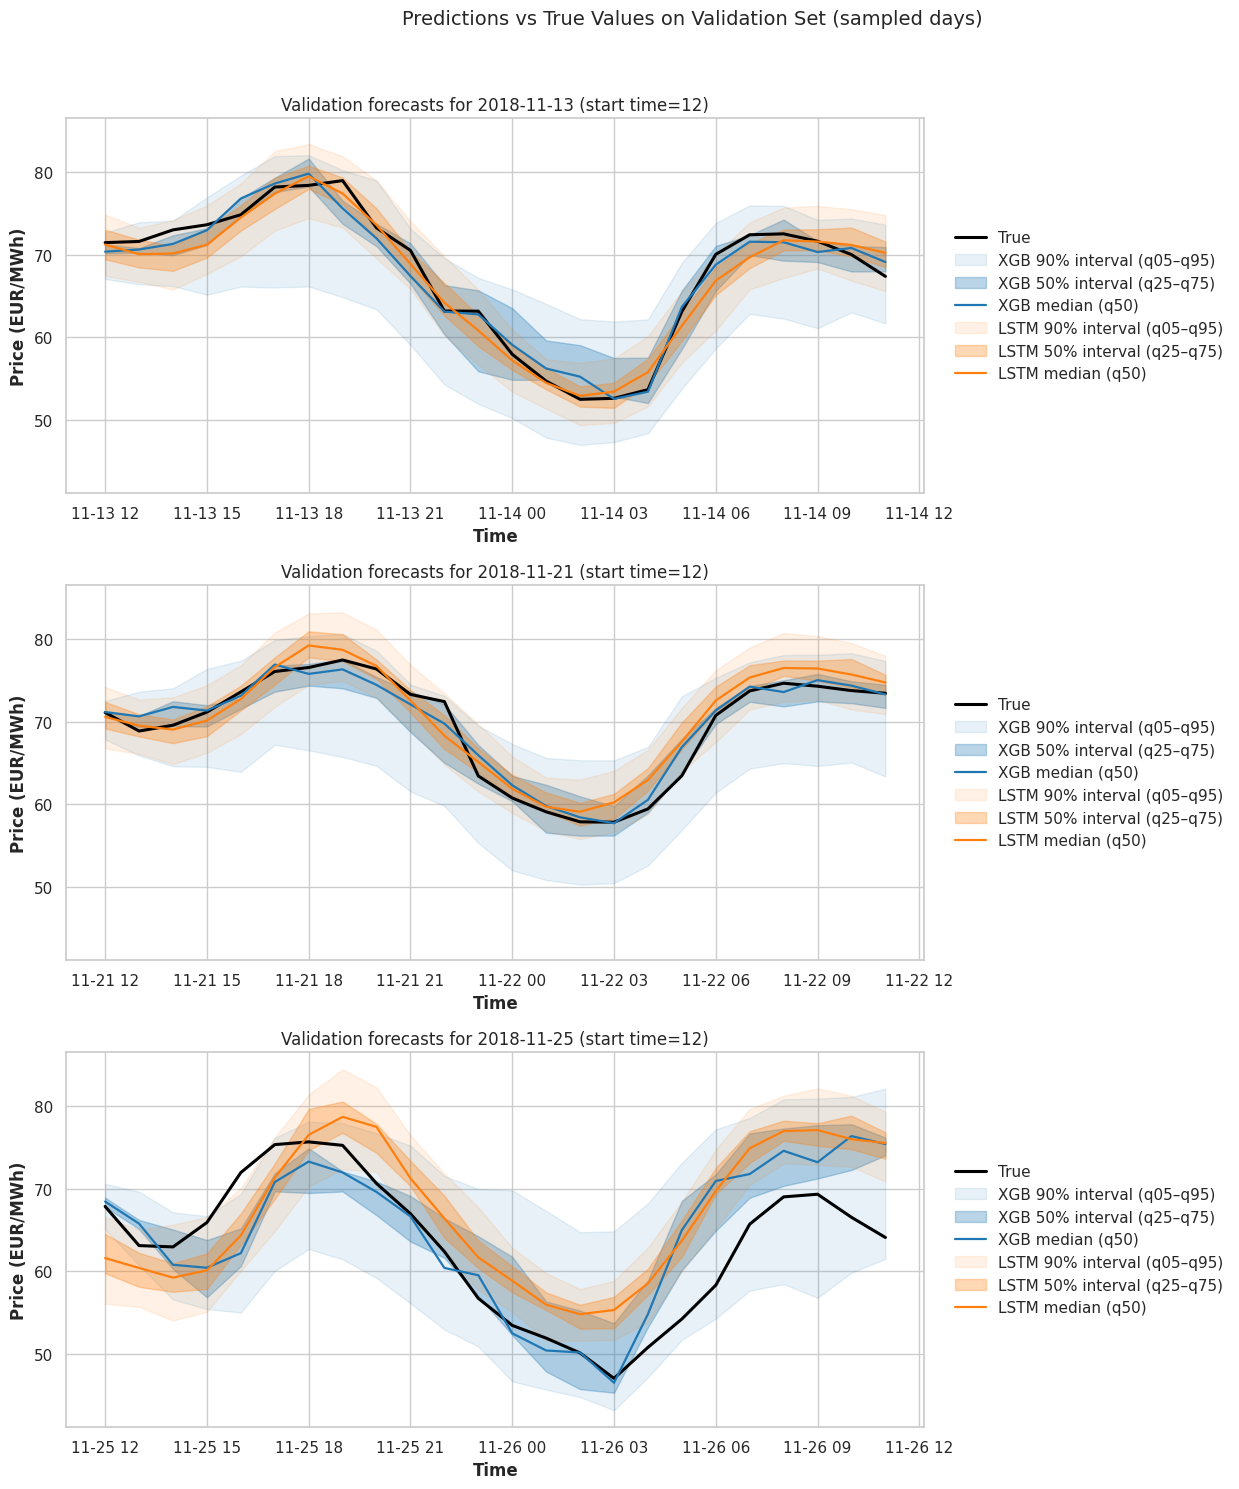

In [155]:
# Prob forecasting on validation set - sampled days
np.random.seed(42)
val_days = y_val_base.time_index.normalize().unique()
sampled_days = np.random.choice(val_days, size=3, replace=False)
sampled_days = np.sort(sampled_days)

# point forecasting on validation set - sampled days
fig, axes = plt.subplots(len(sampled_days), 1, figsize=(14, 16), sharey=True)
if len(sampled_days) == 1:
    axes = [axes]

for ax, day in zip(axes, sampled_days):
    start = day + pd.Timedelta(hours=ISSUE_HOUR)
    end = start + pd.Timedelta(hours=H-1)

    y_true = y_price_val_actual.slice(start, end)

    y_xgb_q05 = pred_val_xgb_q05_on.slice(start, end)
    y_xgb_q25 = pred_val_xgb_q25_on.slice(start, end)
    y_xgb_q50 = pred_val_xgb_q50_on.slice(start, end)
    y_xgb_q75 = pred_val_xgb_q75_on.slice(start, end)
    y_xgb_q95 = pred_val_xgb_q95_on.slice(start, end)

    y_lstm_q05 = pred_val_lstm_q05_on_orig.slice(start, end)
    y_lstm_q25 = pred_val_lstm_q25_on_orig.slice(start, end)
    y_lstm_q50 = pred_val_lstm_50_on_orig.slice(start, end)
    y_lstm_q75 = pred_val_lstm_q75_on_orig.slice(start, end)
    y_lstm_q95 = pred_val_lstm_q95_on_orig.slice(start, end)

    t = y_true.time_index

    # ---- True ----
    ax.plot(
        t, y_true.values(),
        label="True",
        linewidth=2.2,
        color="black",
    )

    # ---- XGB intervals (先画带，再画中位数线) ----
    ax.fill_between(
        t,
        y_xgb_q05.values().flatten(),
        y_xgb_q95.values().flatten(),
        color="tab:blue",
        alpha=0.10,
        label="XGB 90% interval (q05–q95)",
    )
    ax.fill_between(
        t,
        y_xgb_q25.values().flatten(),
        y_xgb_q75.values().flatten(),
        color="tab:blue",
        alpha=0.30,
        label="XGB 50% interval (q25–q75)",
    )
    ax.plot(
        t,
        y_xgb_q50.values(),
        label="XGB median (q50)",
        linestyle="-",
        linewidth=1.6,
        color="tab:blue",
    )

    # ---- LSTM intervals ----
    ax.fill_between(
        t,
        y_lstm_q05.values().flatten(),
        y_lstm_q95.values().flatten(),
        color="tab:orange",
        alpha=0.10,
        label="LSTM 90% interval (q05–q95)",
    )
    ax.fill_between(
        t,
        y_lstm_q25.values().flatten(),
        y_lstm_q75.values().flatten(),
        color="tab:orange",
        alpha=0.30,
        label="LSTM 50% interval (q25–q75)",
    )
    ax.plot(
        t,
        y_lstm_q50.values(),
        label="LSTM median (q50)",
        linestyle="-",
        linewidth=1.6,
        color="tab:orange",
    )
    
    ax.set_title(f"Validation forecasts for {pd.Timestamp(day).date()} (start time={ISSUE_HOUR})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True)

    ax.legend(
        loc="center left",          
        bbox_to_anchor=(1.02, 0.5)
    )

axes[-1].set_xlabel("Time")
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle("Predictions vs True Values on Validation Set (sampled days)", fontsize=14)
fig.tight_layout(rect=[0, 0.05, 0.9, 0.96])

plt.show()

Summary:

- XGBoost clearly outperforms both the naïve baseline and the LSTM models on point forecasting.

- Its 90% prediction interval is also much better calibrated (89.5% coverage vs. 67.4% for LSTM), indicating that XGBoost provides both more accurate and more reliable probabilistic forecasts.

- The XGBoost quantile model (q=0.5) even performs slightly better than the deterministic XGBoost model in terms of point forecasting errors.

- Therefore, we select the XGBoost quantile model as the final model and use it to generate forecasts on the test set.

## 4. Final Evaluation on Test Set

### 4.1 Training on train + val

In [176]:
# ------- Train Probabilistic XGBModel with the best hyperparameters -------
QUANTILES = [0.05, 0.25, 0.5, 0.75, 0.95] 

xgb_prob_final_model = XGBModel(
    # Darts
    lags=lags_target,
    lags_past_covariates=lags_past,
    lags_future_covariates=lags_fut,
    output_chunk_length=H,
    multi_models=True,

    # To XGBRegressor
    likelihood="quantile",
    quantiles=QUANTILES,

    # XGB params
    n_estimators=350,
    learning_rate=xgb_best_params["learning_rate"],
    max_depth=xgb_best_params["max_depth"],
    min_child_weight=xgb_best_params["min_child_weight"],
    subsample=xgb_best_params["subsample"],
    colsample_bytree=xgb_best_params["colsample_bytree"],
    reg_lambda=xgb_best_params["reg_lambda"],
    reg_alpha=xgb_best_params["reg_alpha"],
    gamma=xgb_best_params["gamma"],
    tree_method="hist",
    device="cuda",
    random_state=42,
)

xgb_prob_final_model.fit(
    series=ctx_y_xgb,
    past_covariates=ctx_p_xgb,
    future_covariates=ctx_f_xgb,
    verbose=False,
)


# create models directory if not exists
import os
os.makedirs("models", exist_ok=True)

# Save the final model
final_model_path = "models/xgb_prob_final.pth.tar"
xgb_prob_final_model.save(final_model_path)

print("Saved final model to:", final_model_path)


Saved final model to: models/xgb_prob_final.pth.tar


### 4.2 Test

In [178]:
# load the final model
final_model_path = "models/xgb_prob_final.pth.tar"
xgb_prob_final_model = XGBModel.load(final_model_path)

# Forecast on test set
pred_te_prob_xgb = xgb_prob_final_model.historical_forecasts(
    series= ctx_y_xgb.append(y_te_xgb),           
    past_covariates= ctx_p_xgb.append(past_te_xgb),  
    future_covariates= ctx_f_xgb.append(fut_te_xgb),  
    start=test_start,            
    forecast_horizon=24,
    stride=24,                          
    last_points_only=False,             
    retrain=False,                       
    random_state=42,
    predict_likelihood_parameters=True
)

In [182]:

from darts.metrics import mae, rmse

b0 = pred_te_prob_xgb[0]
pred_te_xgb_q05_flat  = b0.univariate_component(0)
pred_te_xgb_q25_flat  = b0.univariate_component(1)
pred_te_xgb_q50_flat  = b0.univariate_component(2)
pred_te_xgb_q75_flat  = b0.univariate_component(3)
pred_te_xgb_q95_flat  = b0.univariate_component(4)


for b in pred_te_prob_xgb[1:]:
    pred_te_xgb_q05_flat  = pred_te_xgb_q05_flat.append(b.univariate_component(0))
    pred_te_xgb_q25_flat  = pred_te_xgb_q25_flat.append(b.univariate_component(1))
    pred_te_xgb_q50_flat  = pred_te_xgb_q50_flat.append(b.univariate_component(2))
    pred_te_xgb_q75_flat  = pred_te_xgb_q75_flat.append(b.univariate_component(3))
    pred_te_xgb_q95_flat  = pred_te_xgb_q95_flat.append(b.univariate_component(4))

y_true_te_xgb = y_price_test_actual.slice(test_start, test_end)
pred_te_xgb_q05_on = pred_te_xgb_q05_flat.slice(test_start, test_end)
pred_te_xgb_q25_on = pred_te_xgb_q25_flat.slice(test_start, test_end)
pred_te_xgb_q50_on = pred_te_xgb_q50_flat.slice(test_start, test_end)
pred_te_xgb_q75_on = pred_te_xgb_q75_flat.slice(test_start, test_end)
pred_te_xgb_q95_on = pred_te_xgb_q95_flat.slice(test_start, test_end)

# point forecast mae/rmse
mae_te_xgb_q50 = mae(y_true_te_xgb, pred_te_xgb_q50_on)
rmse_te_xgb_q50 = rmse(y_true_te_xgb, pred_te_xgb_q50_on)
print(f"XGB Quantile Model Test MAE (q50): {mae_te_xgb_q50:.4f}")  
print(f"XGB Quantile Model Test RMSE (q50): {rmse_te_xgb_q50:.4f}")  

# coverage 50% and 90%
y = y_true_te_xgb.values().flatten()
q05_xgb_test = pred_te_xgb_q05_on.values().flatten()
q25_xgb_test = pred_te_xgb_q25_on.values().flatten()
q50_xgb_test = pred_te_xgb_q50_on.values().flatten()
q75_xgb_test = pred_te_xgb_q75_on.values().flatten()
q95_xgb_test = pred_te_xgb_q95_on.values().flatten()

coverage_50_xgb_test = np.mean((y >= q25_xgb_test) & (y <= q75_xgb_test))
coverage_90_xgb_test = np.mean((y >= q05_xgb_test) & (y <= q95_xgb_test))

print(f"XGB Quantile Model Test Coverage 50%: {coverage_50_xgb_test:.4f}")
print(f"XGB Quantile Model Test Coverage 90%: {coverage_90_xgb_test:.4f}")


XGB Quantile Model Test MAE (q50): 2.6117
XGB Quantile Model Test RMSE (q50): 3.4450
XGB Quantile Model Test Coverage 50%: 0.3289
XGB Quantile Model Test Coverage 90%: 0.9449


### 4.3 Evaluation and Summary

In [186]:
# Summary of results on Test Set
print("Summary of results on Test Set:")
print(f"Baseline - MAE: {mae_te_baseline:.4f}, RMSE: {rmse_te_baseline:.4f}")
print(f"XGBoost Prob - MAE: {mae_te_xgb_q50:.4f}, RMSE: {rmse_te_xgb_q50:.4f}")
print()
print(f"Coverage 50% interval (q25–q75): {coverage_50_xgb_test:.3%}")
print(f"Coverage 90% interval (q05–q95): {coverage_90_xgb_test:.3%}")


Summary of results on Test Set:
Baseline - MAE: 3.6222, RMSE: 4.8879
XGBoost Prob - MAE: 2.6117, RMSE: 3.4450

Coverage 50% interval (q25–q75): 32.887%
Coverage 90% interval (q05–q95): 94.494%


In [187]:
# calculate the improvements over baseline
improvement_mae = (mae_te_baseline - mae_te_xgb_q50) / mae_te_baseline * 100
improvement_rmse = (rmse_te_baseline - rmse_te_xgb_q50) / rmse_te_baseline * 100
print(f"Improvement over Baseline - MAE: {improvement_mae:.2f}%, RMSE: {improvement_rmse:.2f}%")

Improvement over Baseline - MAE: 27.90%, RMSE: 29.52%


## 5. Forecast Visualization / Case Studies

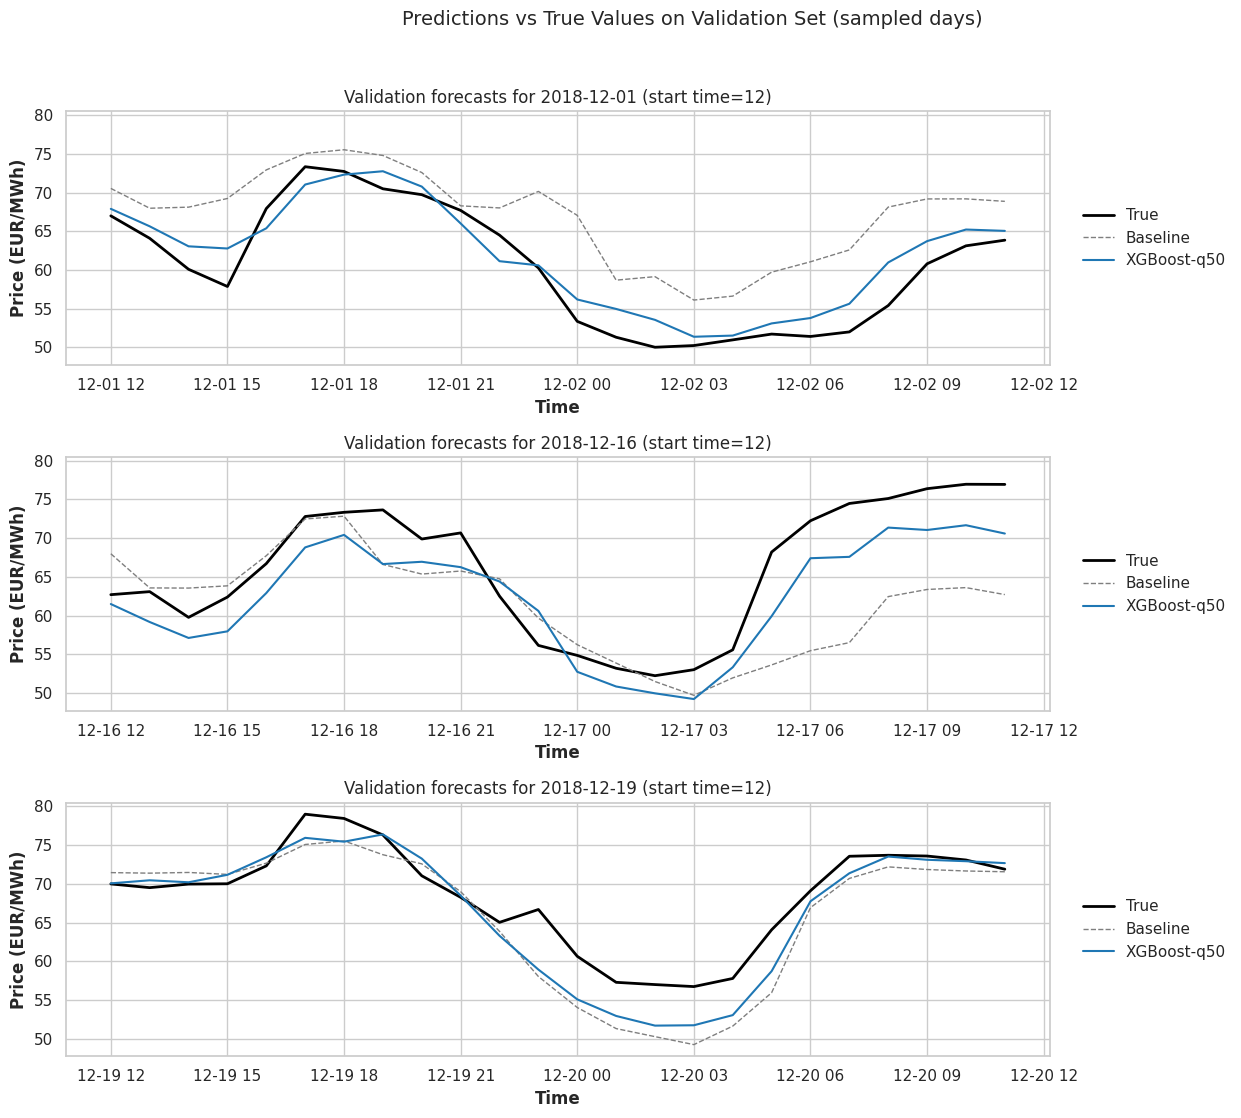

In [194]:
np.random.seed(2025)
test_days = y_te_base.time_index.normalize().unique()
sampled_days = np.random.choice(test_days, size=3, replace=False)
sampled_days = np.sort(sampled_days)

# point forecasting on validation set - sampled days
fig, axes = plt.subplots(len(sampled_days), 1, figsize=(14, 12), sharey=True)
if len(sampled_days) == 1:
    axes = [axes]

for ax, day in zip(axes, sampled_days):
    start = day + pd.Timedelta(hours=ISSUE_HOUR)
    end = start + pd.Timedelta(hours=H-1)

    y_true = y_price_test_actual.slice(start, end)

    y_base = y_price_test_pred_b.slice(start, end)

    y_xgb_q50 = pred_te_xgb_q50_on.slice(start, end)

    
    t = y_true.time_index

    ax.plot(t, y_true.values(),
            label="True",
            linewidth=2,
            color="black")

    ax.plot(t, y_base.values(),
            label="Baseline",
            linestyle="--",
            linewidth=1,
            color="tab:gray")
    
    ax.plot(t, y_xgb_q50.values(),
            label="XGBoost-q50",
            linestyle="-",
            linewidth=1.5,
            color="tab:blue")
    
    ax.set_title(f"Validation forecasts for {pd.Timestamp(day).date()} (start time={ISSUE_HOUR})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True)

    ax.legend(
        loc="center left",          
        bbox_to_anchor=(1.02, 0.5)
    )

axes[-1].set_xlabel("Time")
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle("Predictions vs True Values on Validation Set (sampled days)", fontsize=14)
fig.tight_layout(rect=[0, 0.05, 0.9, 0.96])

plt.show()

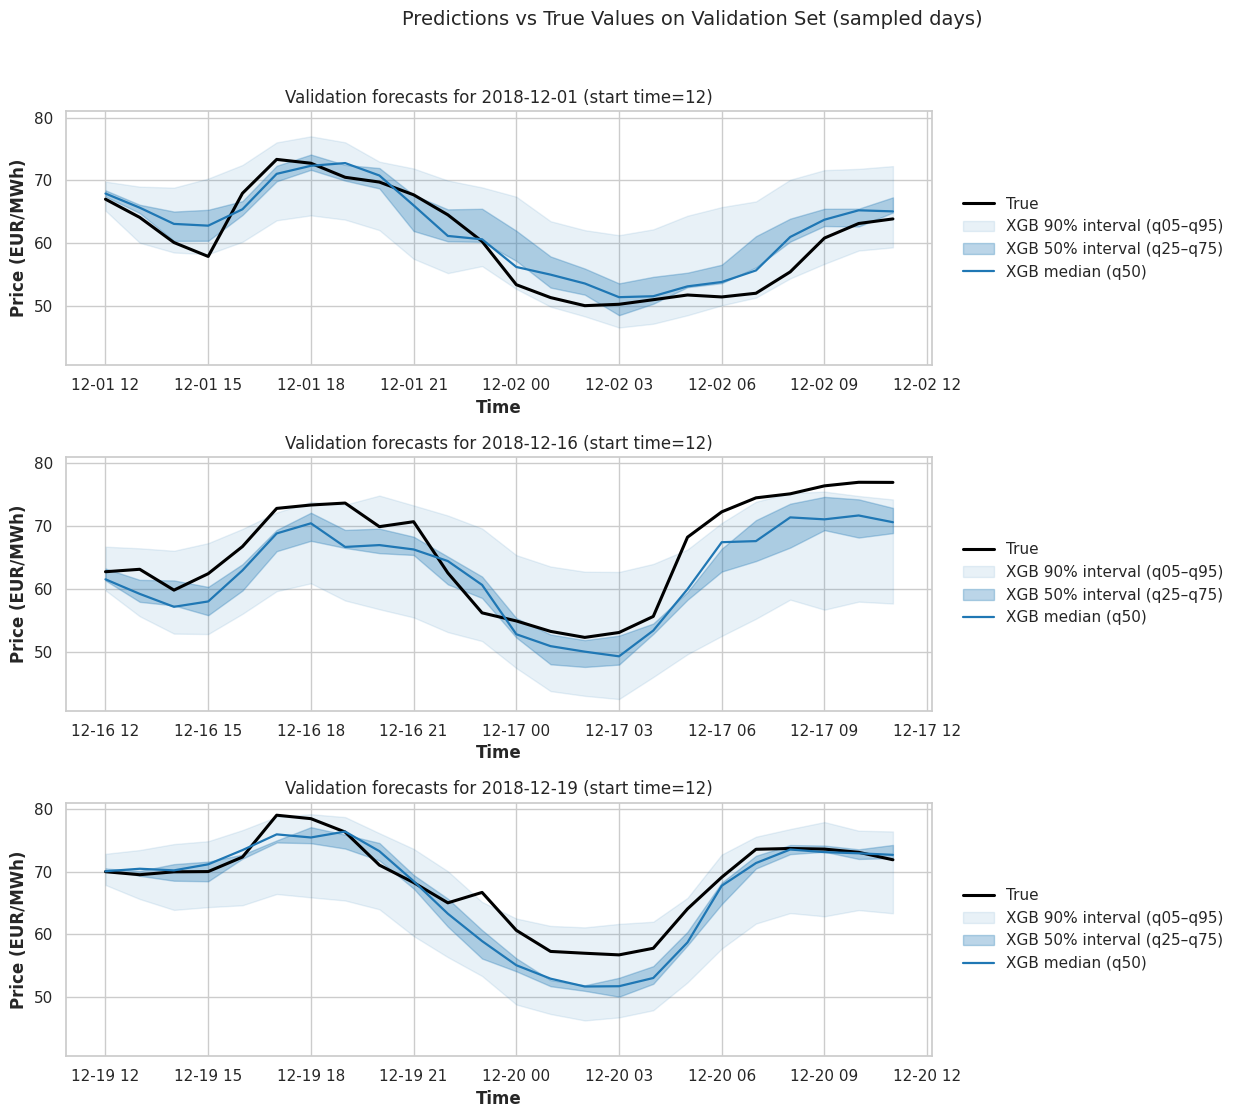

In [195]:
# Prob forecasting on test set - sampled days
np.random.seed(2025)
test_days = y_te_base.time_index.normalize().unique()
sampled_days = np.random.choice(test_days, size=3, replace=False)
sampled_days = np.sort(sampled_days)

fig, axes = plt.subplots(len(sampled_days), 1, figsize=(14, 12), sharey=True)
if len(sampled_days) == 1:
    axes = [axes]

for ax, day in zip(axes, sampled_days):
    start = day + pd.Timedelta(hours=ISSUE_HOUR)
    end = start + pd.Timedelta(hours=H-1)

    y_true = y_price_test_actual.slice(start, end)

    y_xgb_q05 = pred_te_xgb_q05_on.slice(start, end)
    y_xgb_q25 = pred_te_xgb_q25_on.slice(start, end)
    y_xgb_q50 = pred_te_xgb_q50_on.slice(start, end)
    y_xgb_q75 = pred_te_xgb_q75_on.slice(start, end)
    y_xgb_q95 = pred_te_xgb_q95_on.slice(start, end)


    t = y_true.time_index

    # ---- True ----
    ax.plot(
        t, y_true.values(),
        label="True",
        linewidth=2.2,
        color="black",
    )

    # ---- XGB intervals (先画带，再画中位数线) ----
    ax.fill_between(
        t,
        y_xgb_q05.values().flatten(),
        y_xgb_q95.values().flatten(),
        color="tab:blue",
        alpha=0.10,
        label="XGB 90% interval (q05–q95)",
    )
    ax.fill_between(
        t,
        y_xgb_q25.values().flatten(),
        y_xgb_q75.values().flatten(),
        color="tab:blue",
        alpha=0.30,
        label="XGB 50% interval (q25–q75)",
    )
    ax.plot(
        t,
        y_xgb_q50.values(),
        label="XGB median (q50)",
        linestyle="-",
        linewidth=1.6,
        color="tab:blue",
    )
    
    ax.set_title(f"Validation forecasts for {pd.Timestamp(day).date()} (start time={ISSUE_HOUR})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True)

    ax.legend(
        loc="center left",          
        bbox_to_anchor=(1.02, 0.5)
    )

axes[-1].set_xlabel("Time")
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle("Predictions vs True Values on Validation Set (sampled days)", fontsize=14)
fig.tight_layout(rect=[0, 0.05, 0.9, 0.96])

plt.show()

## 6. Summary

After a robust data preprocessing, data engineering, hyperparameter tuning, model selection, we obtain a high accurate model:
- **Model hierarchy:** The probabilistic XGBoost model outperforms both the naïve baseline (lag 24) and the LSTM.  

- **Point forecast accuracy:** On the test set, MAE is reduced from **3.62 → 2.61** and RMSE from **4.89 → 3.45**, corresponding to roughly **28% (MAE)** and **30% (RMSE)** improvement over the baseline.  

- **Probabilistic performance:** XGBoost-QR produces **well-calibrated prediction intervals**, with over 90% coverage consistent with the nominal 90% level.  

- **Final conclusion:** XGBoost-QR is selected as the **final model** for day-ahead electricity price forecasting, providing both **more accurate** and **more reliable** forecasts than the alternatives.



# End